## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5rawre' #dataset-compression
TRANSFORM = 'cwt-statement_2' #transform-group
CHANNEL = ''
NUM_BANDS = int(10) 

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
statement_2_cwt_1e5rawre_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5rawre\\cwt\\statement_2'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


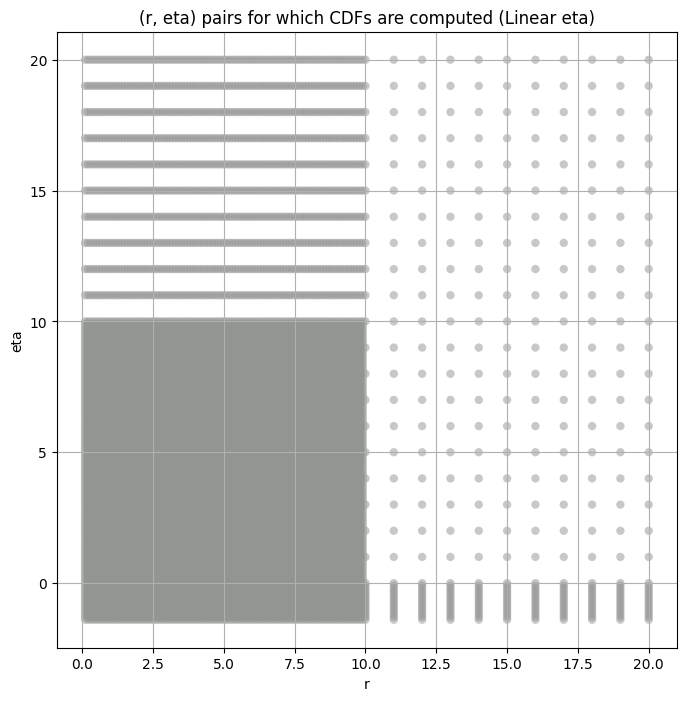

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     9.304439e+08  8.450695e+08  1.021509e+09  11.473390    9.685302   
5     2.322291e+09  2.175008e+09  2.474092e+09   4.320653    3.779683   
8     1.710829e+09  1.607269e+09  1.818124e+09   3.818767    3.301207   
11    1.497775e+09  1.413093e+09  1.583780e+09   2.941873    2.638871   
14    3.499311e+08  3.208751e+08  3.802060e+08   8.869143    7.774240   
18    7.146146e+07  6.552034e+07  7.788669e+07   9.265934    7.092388   
21    2.790665e+07  2.514312e+07  3.095792e+07  14.160641   10.133566   
24    2.332932e+07  2.041269e+07  2.649432e+07  23.594398   19.808994   
27    1.140600e+07  9.829746e+06  1.310639e+07  29.102272   24.468290   
31    2.927760e+05  2.422451e+05  3.579953e+05  55.067830   33.236103   

      kurt_upper  total_samples  
band                             
2      14.099253       100000.0  
5       4.902255       100000.0  
8       4.360001       100000.0  
11      3.259851       100000.0  
14     10.038318       100000.0  
18     12.380857       100000.0  
21     20.465760       100000.0  
24     27.871244       100000.0  
27     34.380190       100000.0  
31    140.556670       100000.0

## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                                
2     9.304439e+08   9.304439e+08    9.017939e+08    8.818900e+08   
5     2.322291e+09   2.322291e+09    2.286694e+09    2.257126e+09   
8     1.710829e+09   1.710829e+09    1.685650e+09    1.663971e+09   
11    1.497775e+09   1.497775e+09    1.482960e+09    1.469706e+09   
14    3.499311e+08   3.499311e+08    3.417864e+08    3.350210e+08   
18    7.146146e+07   7.146146e+07    6.905330e+07    6.740460e+07   
21    2.790665e+07   2.790665e+07    2.661240e+07    2.578298e+07   
24    2.332932e+07   2.332932e+07    2.220328e+07    2.133863e+07   
27    1.140600e+07   1.140600e+07    1.079163e+07    1.031730e+07   
31    2.927760e+05   2.927760e+05    2.648931e+05    2.490024e+05   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2       8.644082e+08     8.484132e+08     8.195105e+08     7.935359e+08   
5       2.230384e+09     2.205565e+09     2.160123e+09     2.118764e+09   
8       1.644313e+09     1.626237e+09     1.593635e+09     1.564429e+09   
11      1.457265e+09     1.445423e+09     1.423109e+09     1.402219e+09   
14      3.289517e+08     3.233757e+08     3.133043e+08     3.042924e+08   
18      6.602397e+07     6.481264e+07     6.272512e+07     6.093937e+07   
21      2.510857e+07     2.452949e+07     2.355534e+07     2.274402e+07   
24      2.059198e+07     1.992478e+07     1.875905e+07     1.775630e+07   
27      9.908300e+06     9.543398e+06     8.907322e+06     8.362116e+06   
31      2.360988e+05     2.250160e+05     2.064586e+05     1.911651e+05   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2        7.697836e+08     7.478289e+08     7.273641e+08     6.730259e+08  
5        2.080468e+09     2.044637e+09     2.010849e+09     1.919017e+09  
8        1.537720e+09     1.512967e+09     1.489746e+09     1.426935e+09  
11       1.382466e+09     1.363659e+09     1.345669e+09     1.295633e+09  
14       2.960706e+08     2.884807e+08     2.814165e+08     2.626245e+08  
18       5.936372e+07     5.794580e+07     5.665191e+07     5.331830e+07  
21       2.204320e+07     2.142314e+07     2.086476e+07     1.944168e+07  
24       1.687308e+07     1.608275e+07     1.536773e+07     1.356372e+07  
27       7.883323e+06     7.456448e+06     7.071602e+06     6.105964e+06  
31       1.781369e+05     1.668112e+05     1.568271e+05     1.326711e+05

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.023566765934815492 930443900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.023983612125578646 901793900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.024701315366159937 881890050.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.025350073508423887 864408200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.02595427823057911 848413250.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.02649344458643388 819510460.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.025871689438516768 793535940.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.02649344458643388 769783600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.02649344458643388 747828900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.02649344458643388 727364100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.02649344458643388 673025900.0
Number of samples: 100000, Without approximation : 100000.0


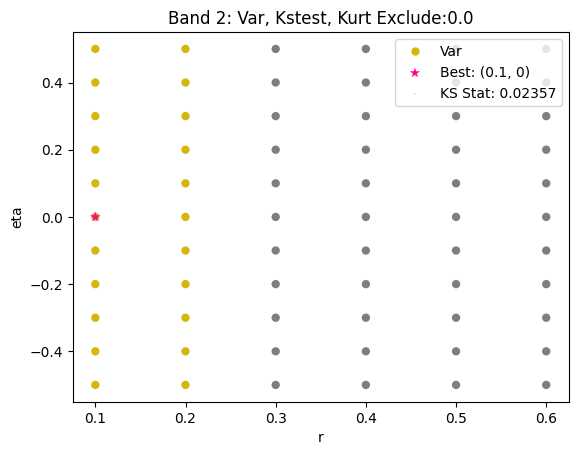

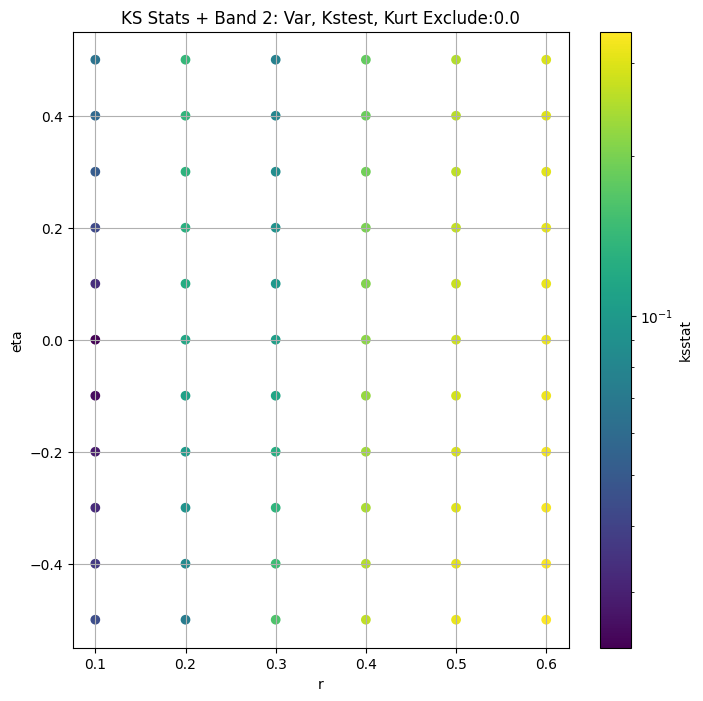

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.032635441041809266 2322291200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.03217030697555934 2286694100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.032389423129891876 2257126100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.03311873022777642 2230383900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.03380379761924479 2205565200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.034989757249837994 2160122600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.03439882869649025 2118764300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.0342379508990891 2080468500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.035302279392265934 2044636700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.036325007358577424 2010848600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.03647813250394716 1919016800.0
Number of samples: 100000, Without approximation : 100000.0


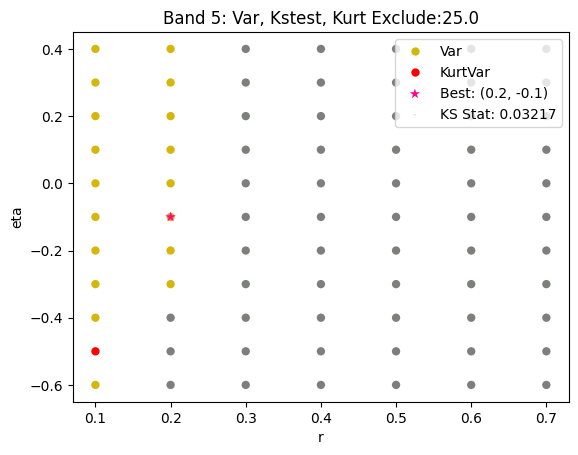

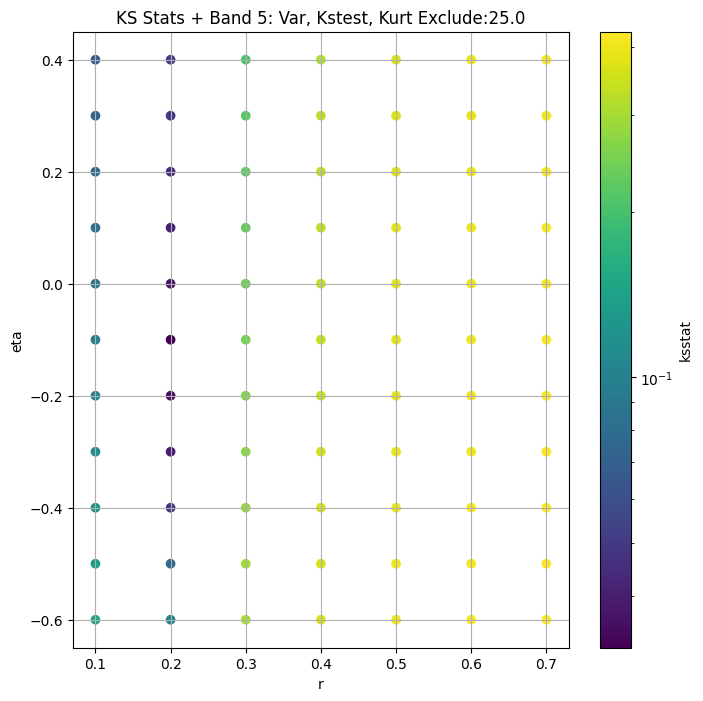

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.023926446914061428 1710828900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.024134955339596864 1685649700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.023749024773927485 1663970700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.024275088912705772 1644312700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.025079828157554718 1626236900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.02485111084548053 1593635000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.025644671403516783 1564428700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.025992395051051997 1537720300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.02606925343687004 1512967200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.02709127489546148 1489745500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.027675060846182875 1426935300.0
Number of samples: 100000, Without approximation : 100000.0


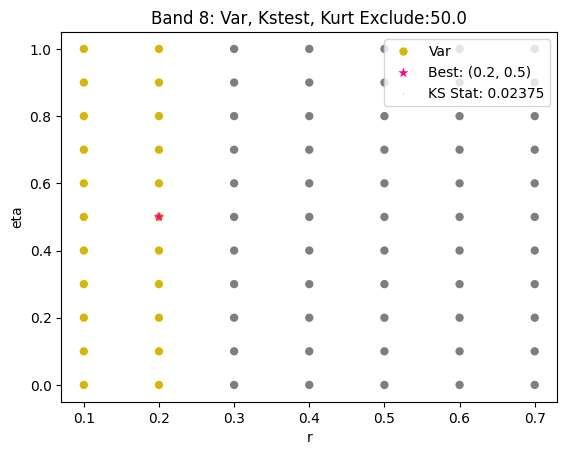

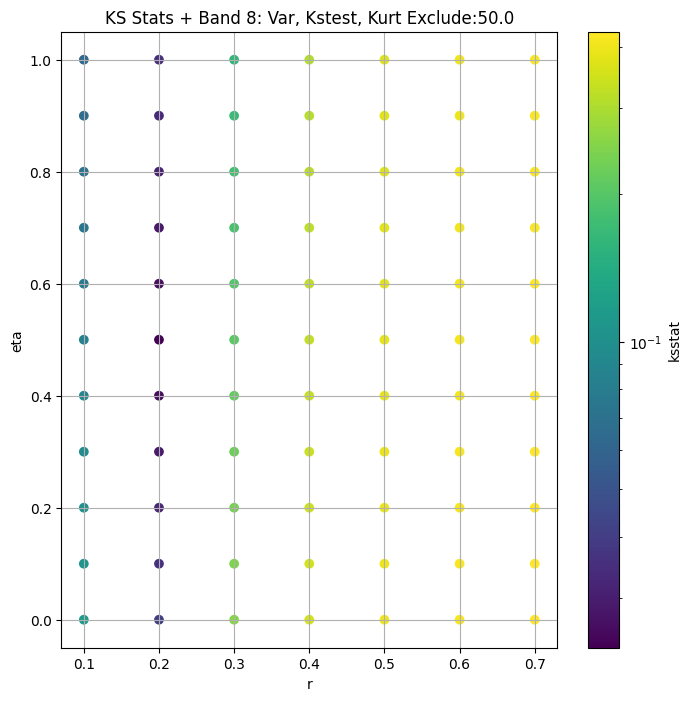

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.030462065411415717 1497774700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.030076949627379057 1482959700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.030508351400756806 1469706200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.031024208410088155 1457265200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.0315192653990074 1445422800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.032463872685820516 1423108700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.032274590261553215 1402218900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.031943071575519275 1382466300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.03276965779599457 1363659000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.03357214823840983 1345669200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.033889005169527045 1295632800.0
Number of samples: 100000, Without approximation : 100000.0


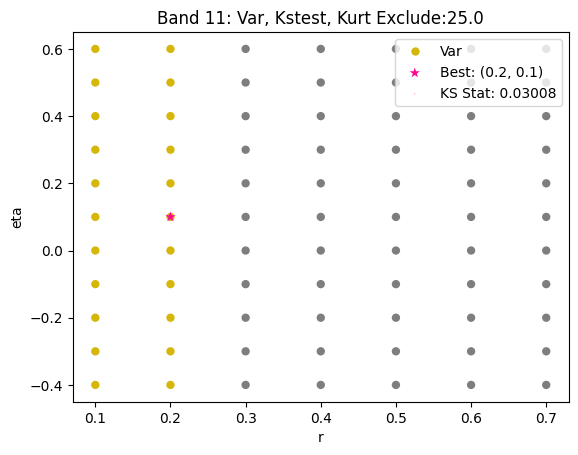

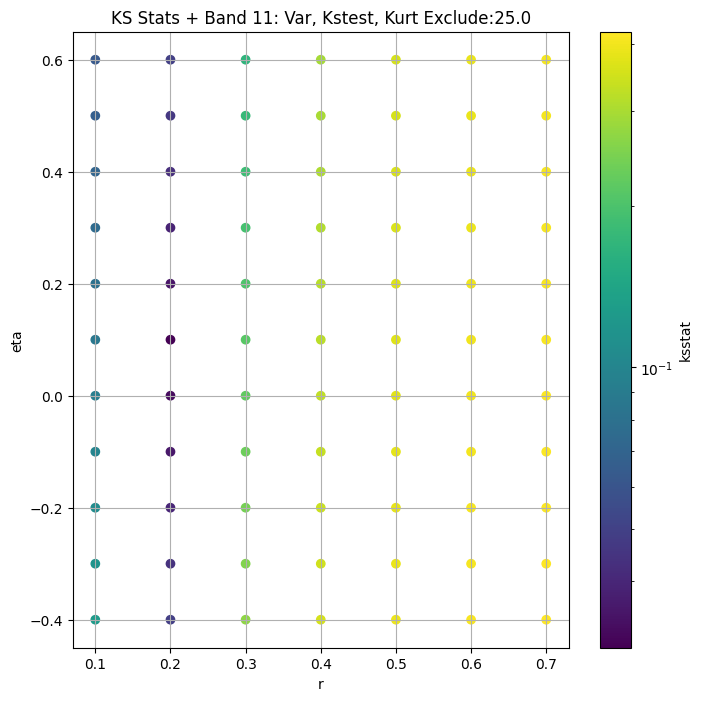

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.017966953548243403 349931100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.017437684403248527 341786400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.018464573215464936 335021000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.01940819112160086 328951700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.02029470728205418 323375680.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.0219341238360512 313304260.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.021987123454473678 304292380.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.020919878940921177 296070600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.021930874603332318 288480740.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.023202651138210073 281416500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.024378764253828122 262624500.0
Number of samples: 100000, Without approximation : 100000.0


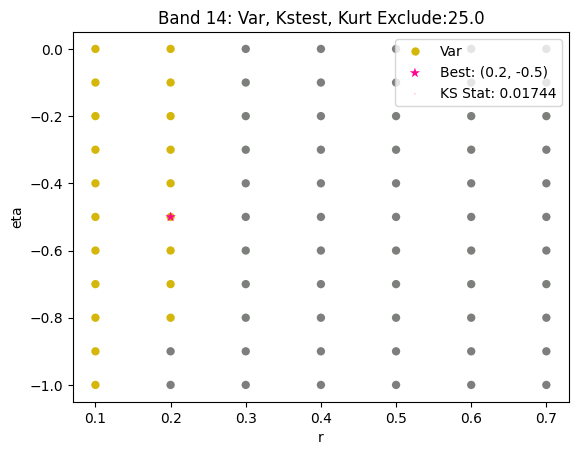

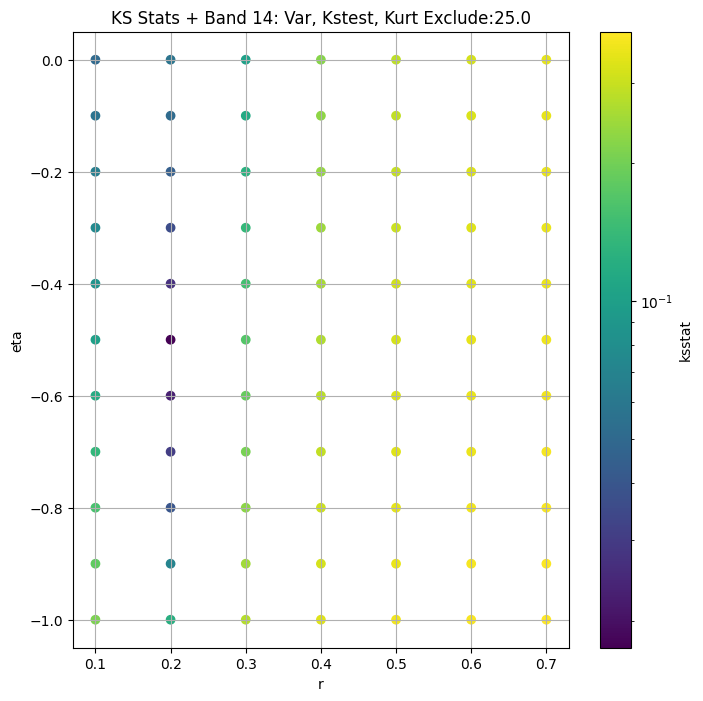

####
Band  18


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 0 0.016094383170416324 71461464.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 25 0.017994160699296116 69053304.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 50 0.018595347323713096 67404600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 75 0.017985398297836852 66023972.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 100 0.018649969670078148 64812644.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 150 0.020436766225446545 62725124.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 200 0.020085613822424908 60939372.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 250 0.021086172102706385 59363720.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 300 0.022395581793410432 57945804.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 350 0.021945672887055068 56651910.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 500 0.02379292594907023 53318296.0
Number of samples: 100000, Without approximation : 100000.0


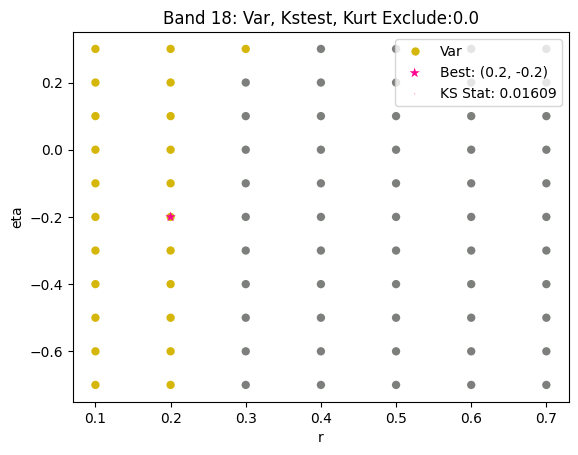

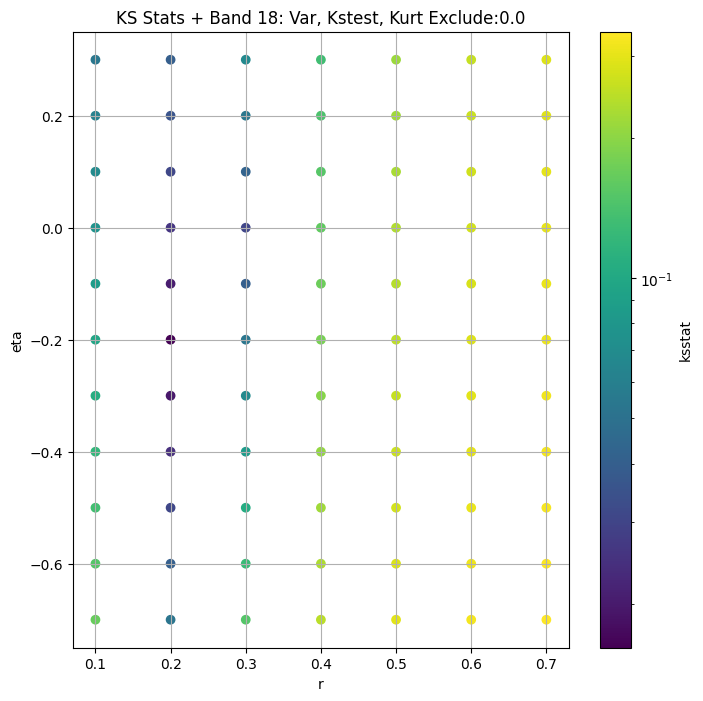

####
Band  21


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 0 0.014981785531745076 27906646.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 25 0.01578939167844451 26612398.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 50 0.014832897254160926 25782982.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 75 0.015882413682292387 25108570.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 100 0.017130992261641123 24529492.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 150 0.018985061674862802 23555340.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 200 0.017862812839507414 22744016.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 250 0.01908894197194433 22043198.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 300 0.020583786700904425 21423138.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 350 0.02127135564117766 20864762.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 500 0.022671523233793997 19441684.0
Number of samples: 100000, Without approximation : 100000.0


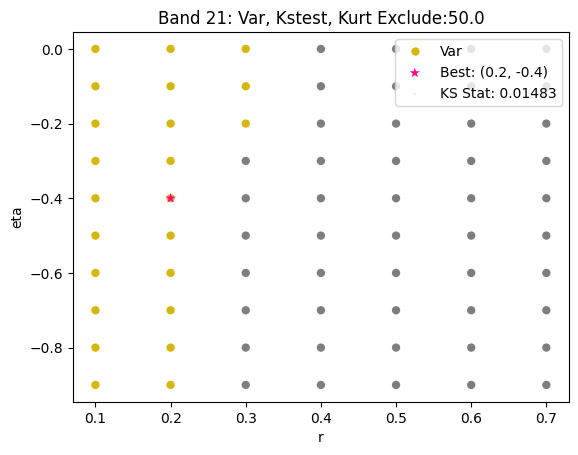

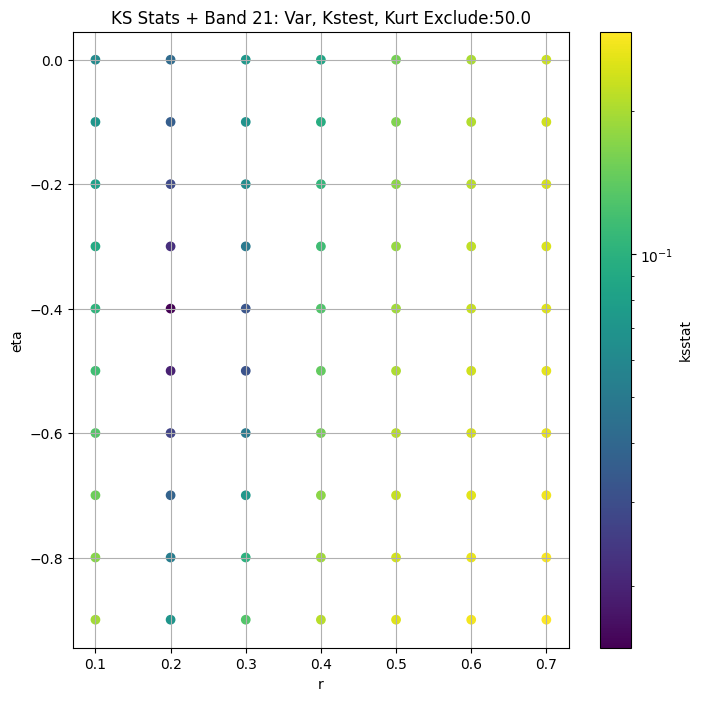

####
Band  24


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 0 0.008031287135787601 23329316.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 25 0.00932312616790422 22203280.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 50 0.010400608684740534 21338630.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 75 0.01139534247764358 20591980.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 100 0.012366400621583812 19924782.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 150 0.014279994709192556 18759046.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 200 0.01365022014502304 17756302.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 250 0.012461350062152203 16873080.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 300 0.013726153016942008 16082751.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 350 0.014965938999452248 15367726.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 500 0.018614418631962698 13563725.0
Number of samples: 100000, Without approximation : 100000.0


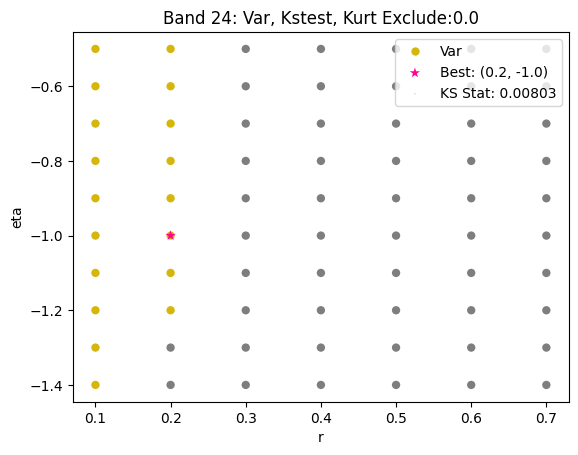

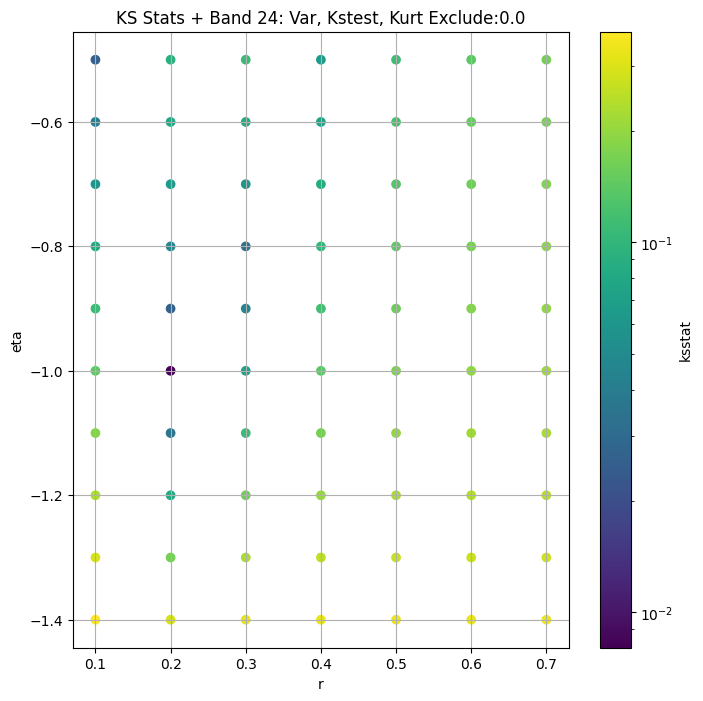

####
Band  27


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 0 0.013189886003386775 11405998.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 25 0.012105893824365666 10791632.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 50 0.010086154753345677 10317304.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 75 0.00975538530321185 9908300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 100 0.010777061255546339 9543398.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 150 0.012729230226465438 8907322.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 200 0.014605552558327073 8362116.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 250 0.01582100255095114 7883323.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 300 0.016797614926754502 7456447.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 350 0.01773928615361589 7071602.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 500 0.014330619788851966 6105964.5
Number of samples: 100000, Without approximation : 100000.0


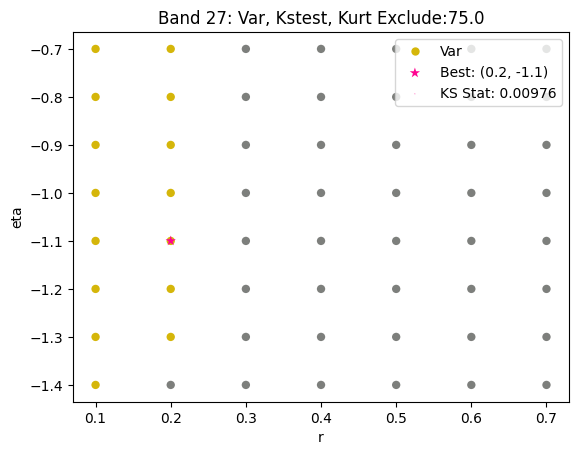

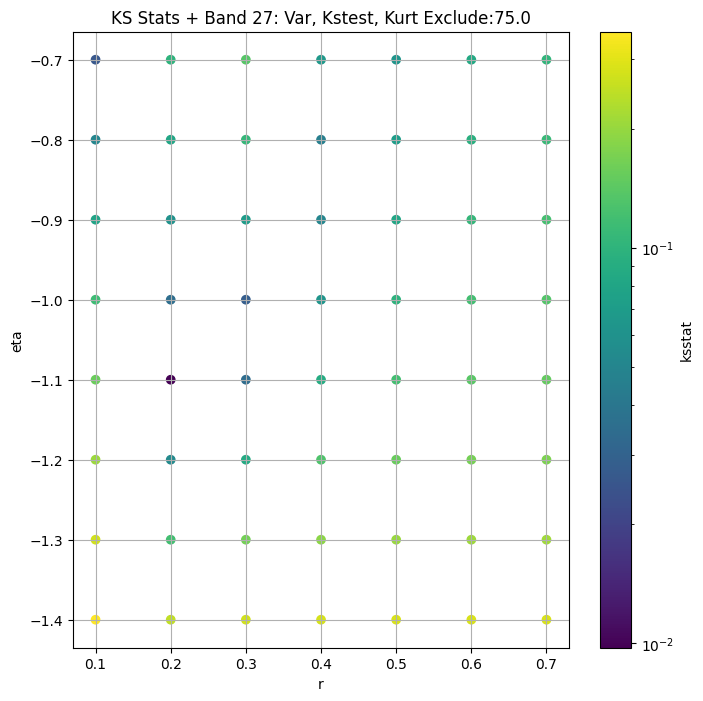

####
Band  31


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 0 0.03241882108622807 292776.03


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 25 0.03221812052958628 264893.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 50 0.03209149102016928 249002.36


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 75 0.03198092623874693 236098.77


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 100 0.03187978742232067 225016.03


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 150 0.03169699038623308 206458.58


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 200 0.03153118272127531 191165.11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 250 0.03137708504980652 178136.89


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 300 0.031232183161485016 166811.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 350 0.03109481953866744 156827.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 500 0.03121814262705286 132671.14
Number of samples: 100000, Without approximation : 100000.0


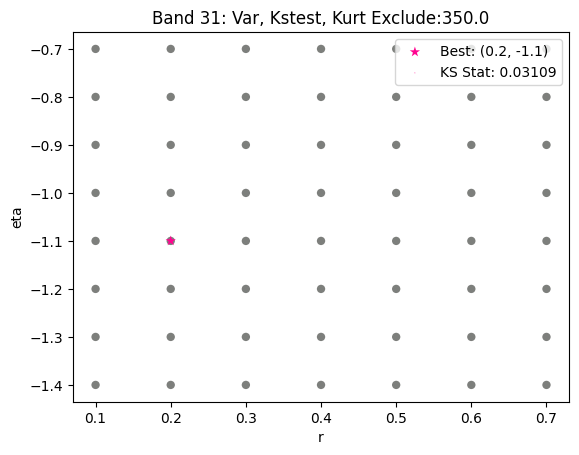

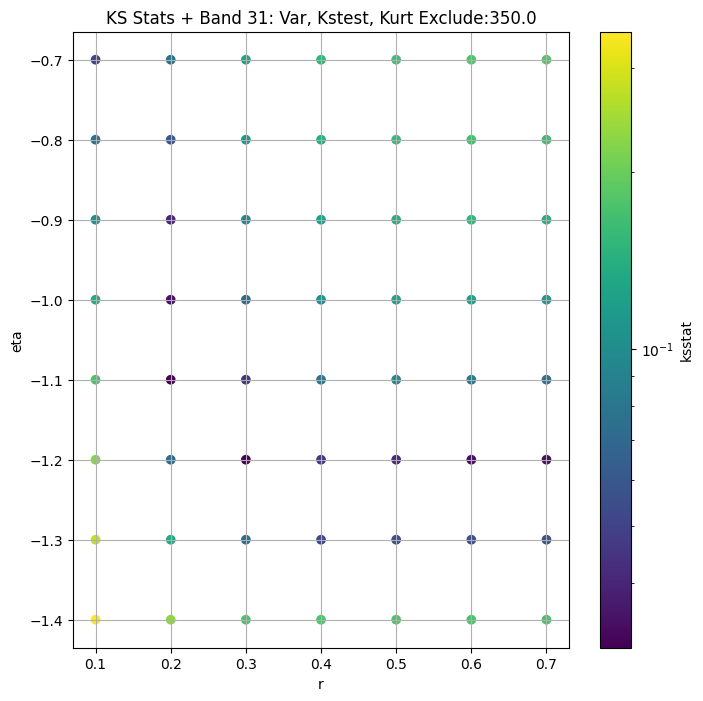

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     9.304439e+08  8.450695e+08  1.021509e+09  11.473390    9.685302   
5     2.322291e+09  2.175008e+09  2.474092e+09   4.320653    3.779683   
8     1.710829e+09  1.607269e+09  1.818124e+09   3.818767    3.301207   
11    1.497775e+09  1.413093e+09  1.583780e+09   2.941873    2.638871   
14    3.499311e+08  3.208751e+08  3.802060e+08   8.869143    7.774240   
18    7.146146e+07  6.552034e+07  7.788669e+07   9.265934    7.092388   
21    2.790665e+07  2.514312e+07  3.095792e+07  14.160641   10.133566   
24    2.332932e+07  2.041269e+07  2.649432e+07  23.594398   19.808994   
27    1.140600e+07  9.829746e+06  1.310639e+07  29.102272   24.468290   
31    2.927760e+05  2.422451e+05  3.579953e+05  55.067830   33.236103   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      14.099253       100000.0             0.023567        0.1          0.0   
5       4.902255       100000.0             0.032170        0.2         -0.1   
8       4.360001       100000.0             0.023749        0.2          0.5   
11      3.259851       100000.0             0.030077        0.2          0.1   
14     10.038318       100000.0             0.017438        0.2         -0.5   
18     12.380857       100000.0             0.016094        0.2         -0.2   
21     20.465760       100000.0             0.014833        0.2         -0.4   
24     27.871244       100000.0             0.008031        0.2         -1.0   
27     34.380190       100000.0             0.009755        0.2         -1.1   
31    140.556670       100000.0             0.031095        0.2         -1.1   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2          0.000131                     0.0        9.304439e+08   
5      41246.286869                    25.0        2.286694e+09   
8       6926.284915                    50.0        1.663971e+09   
11     15603.532660                    25.0        1.482960e+09   
14     22604.920635                    25.0        3.417864e+08   
18      1728.882423                     0.0        7.146146e+07   
21      1190.839701                    50.0        2.578298e+07   
24     16573.162660                     0.0        2.332932e+07   
27     13761.527778                    75.0        9.908300e+06   
31       217.815408                   350.0        1.568271e+05   

      kstest_stat_cutoff_0.05  
band                           
2                    0.004293  
5                    0.004293  
8                    0.004293  
11                   0.004293  
14                   0.004293  
18                   0.004293  
21                   0.004293  
24                   0.004293  
27                   0.004293  
31                   0.004293

In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 2, 0.0 + 100 = 100, ksstat: 0.0242831045487375, var: 848413248.0


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 2, 0.0 + 75 = 75, ksstat: 0.023990011890169013, var: 864408192.0


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 2, 0.0 + 50 = 50, ksstat: 0.02334817362660946, var: 881890048.0


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 2, 0.0 + 25 = 25, ksstat: 0.022632097295408826, var: 901793920.0


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 2, 0.0 + 0 = 0, ksstat: 0.02162641028467549, var: 930443904.0
Number of samples: 100000, Without approximation : 100000.0


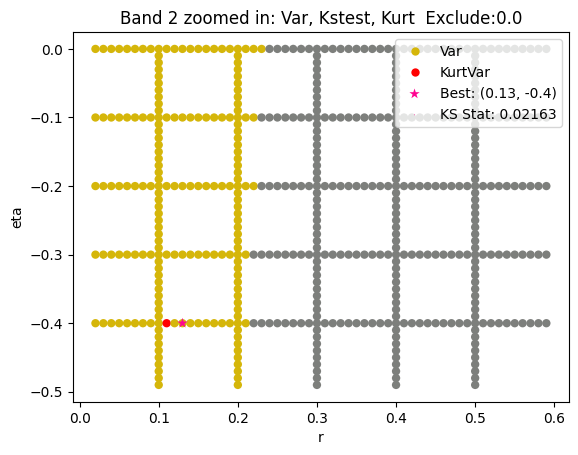

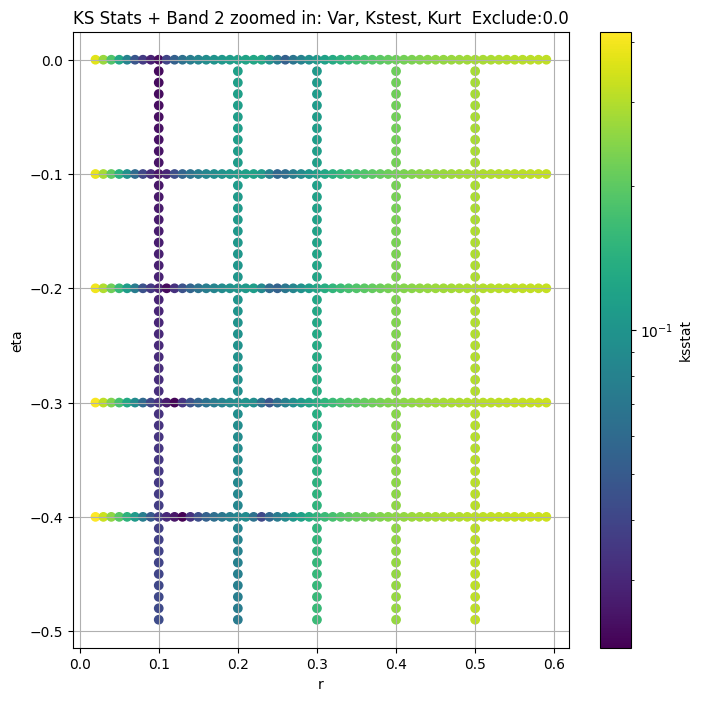

Band 5


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 5, 25.0 + 100 = 125, ksstat: 0.033092282853594, var: 2182238720.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 5, 25.0 + 75 = 100, ksstat: 0.03281072299548951, var: 2205565184.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 5, 25.0 + 50 = 75, ksstat: 0.03245186912111225, var: 2230383872.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 5, 25.0 + 25 = 50, ksstat: 0.032256058858236514, var: 2257126144.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 5, 25.0 + 0 = 25, ksstat: 0.03193473085243877, var: 2286694144.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 5, 25.0 + -25 = 0, ksstat: 0.031660953585116114, var: 2322291200.0
Number of samples: 100000, Without approximation : 100000.0


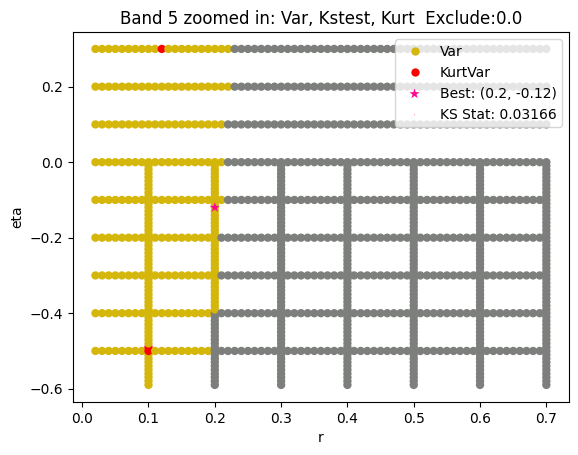

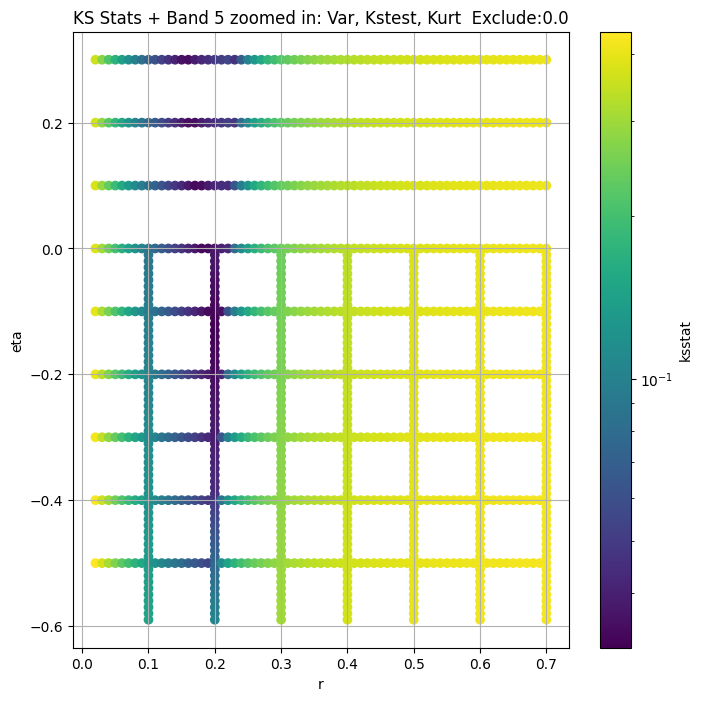

Band 8


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 50.0 + 100 = 150, ksstat: 0.023931671787997266, var: 1593634944.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 50.0 + 75 = 125, ksstat: 0.02422865414573533, var: 1609430400.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 50.0 + 50 = 100, ksstat: 0.024544155526122435, var: 1626236928.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 50.0 + 25 = 75, ksstat: 0.023964797877745414, var: 1644312704.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 50.0 + 0 = 50, ksstat: 0.02310770867058687, var: 1663970688.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 50.0 + -25 = 25, ksstat: 0.023487073576842654, var: 1685649664.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 50.0 + -50 = 0, ksstat: 0.023763506694245456, var: 1710828928.0
Number of samples: 100000, Without approximation : 100000.0


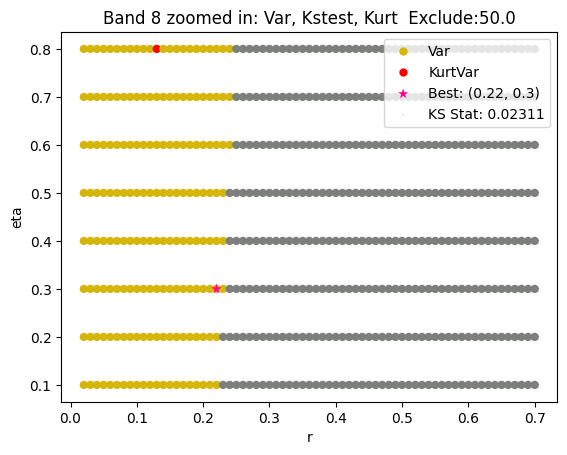

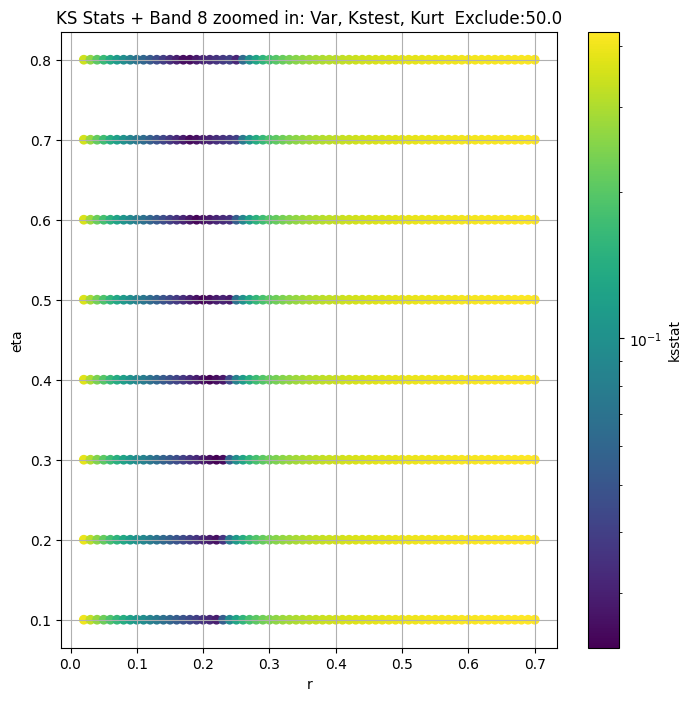

Band 11


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 11, 25.0 + 100 = 125, ksstat: 0.030909915083467243, var: 1434062976.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 11, 25.0 + 75 = 100, ksstat: 0.031219029196308035, var: 1445422848.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 11, 25.0 + 50 = 75, ksstat: 0.031024208410088155, var: 1457265152.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 11, 25.0 + 25 = 50, ksstat: 0.030508351400756806, var: 1469706240.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 11, 25.0 + 0 = 25, ksstat: 0.030076949627379057, var: 1482959744.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 11, 25.0 + -25 = 0, ksstat: 0.029523039978972418, var: 1497774720.0
Number of samples: 100000, Without approximation : 100000.0


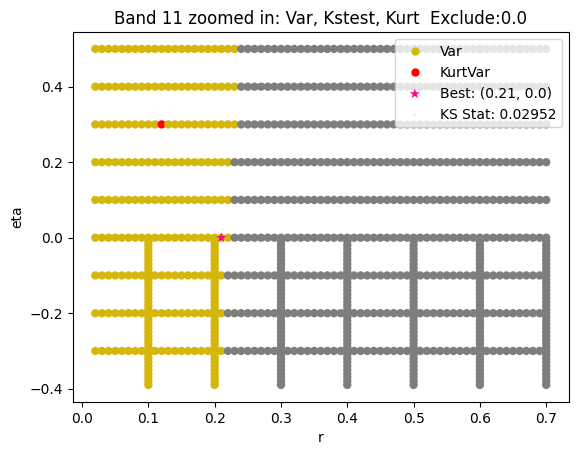

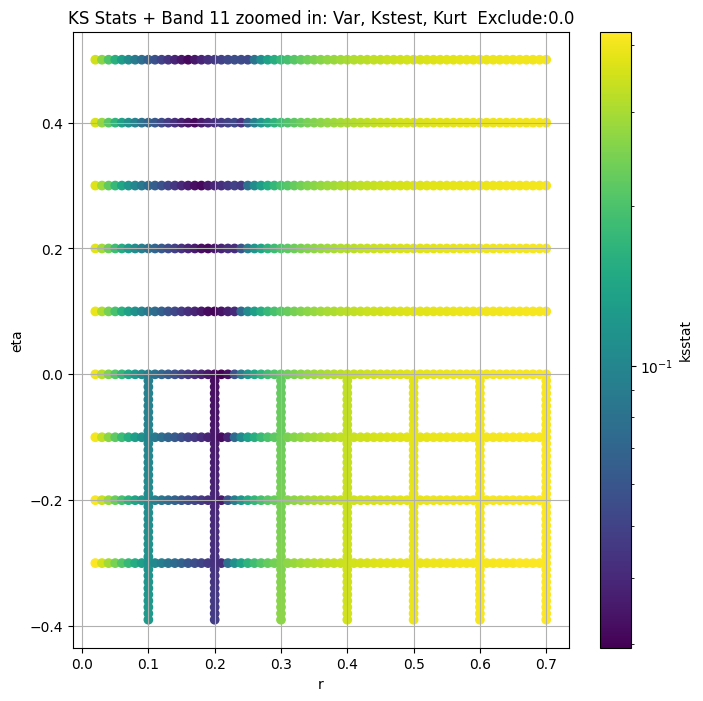

Band 14


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + 100 = 125, ksstat: 0.019156756664662877, var: 318182016.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + 75 = 100, ksstat: 0.018864110134978462, var: 323375680.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + 50 = 75, ksstat: 0.018488123287287064, var: 328951712.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + 25 = 50, ksstat: 0.018001784972570045, var: 335020992.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + 0 = 25, ksstat: 0.017437684403248527, var: 341786400.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 25.0 + -25 = 0, ksstat: 0.016949373362182163, var: 349931104.0
Number of samples: 100000, Without approximation : 100000.0


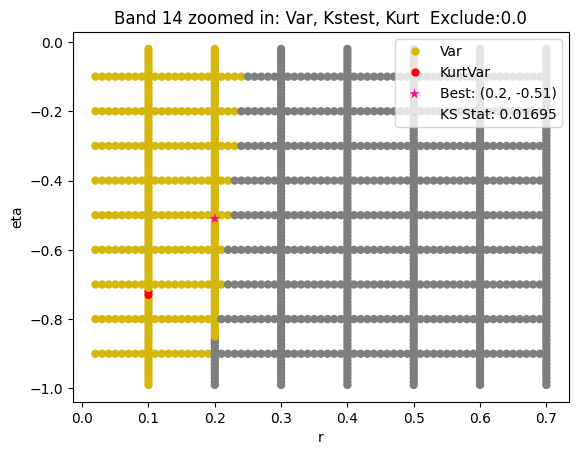

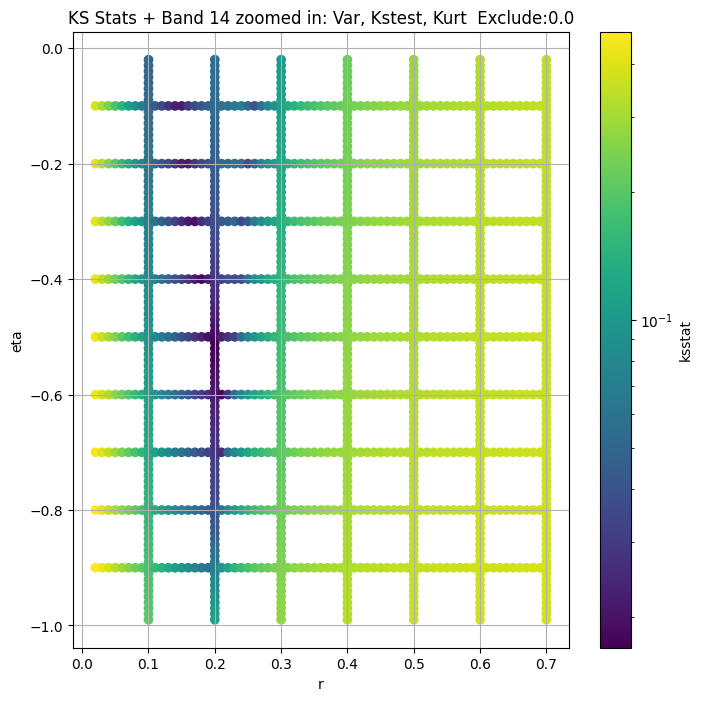

Band 18


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 100 = 100, ksstat: 0.017048601394850996, var: 64812644.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 75 = 75, ksstat: 0.01605150464441303, var: 66023972.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 50 = 50, ksstat: 0.016615337132522057, var: 67404600.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 25 = 25, ksstat: 0.015424358463078089, var: 69053304.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 0 = 0, ksstat: 0.015092399701545703, var: 71461464.0
Number of samples: 100000, Without approximation : 100000.0


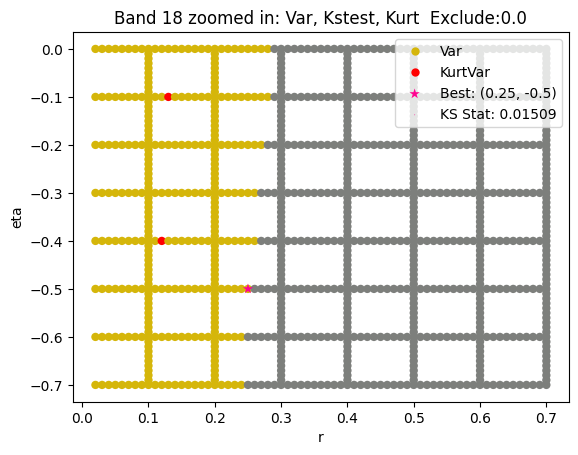

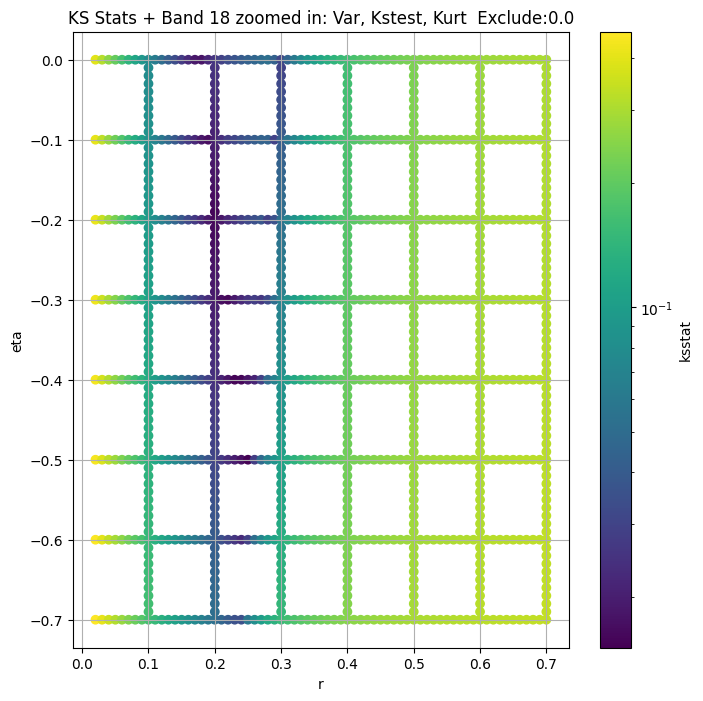

Band 21


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 21, 50.0 + 100 = 150, ksstat: 0.015418031638298607, var: 23555340.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 21, 50.0 + 75 = 125, ksstat: 0.014415073548304028, var: 24017258.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 21, 50.0 + 50 = 100, ksstat: 0.014171994366056095, var: 24529492.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 21, 50.0 + 25 = 75, ksstat: 0.01423009639399074, var: 25108570.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 21, 50.0 + 0 = 50, ksstat: 0.012850025480081906, var: 25782982.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 21, 50.0 + -25 = 25, ksstat: 0.011664601955320875, var: 26612398.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 21, 50.0 + -50 = 0, ksstat: 0.011246214687153921, var: 27906646.0
Number of samples: 100000, Without approximation : 100000.0


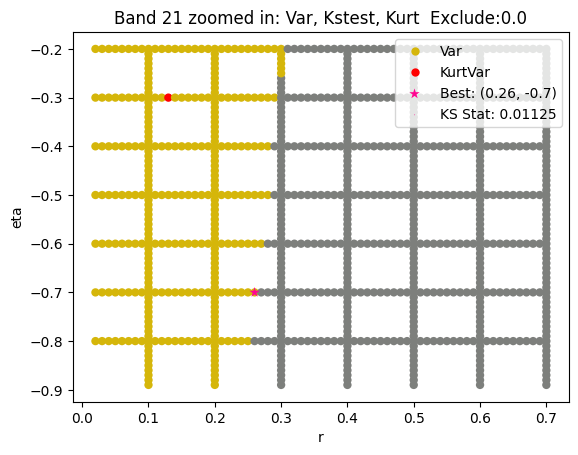

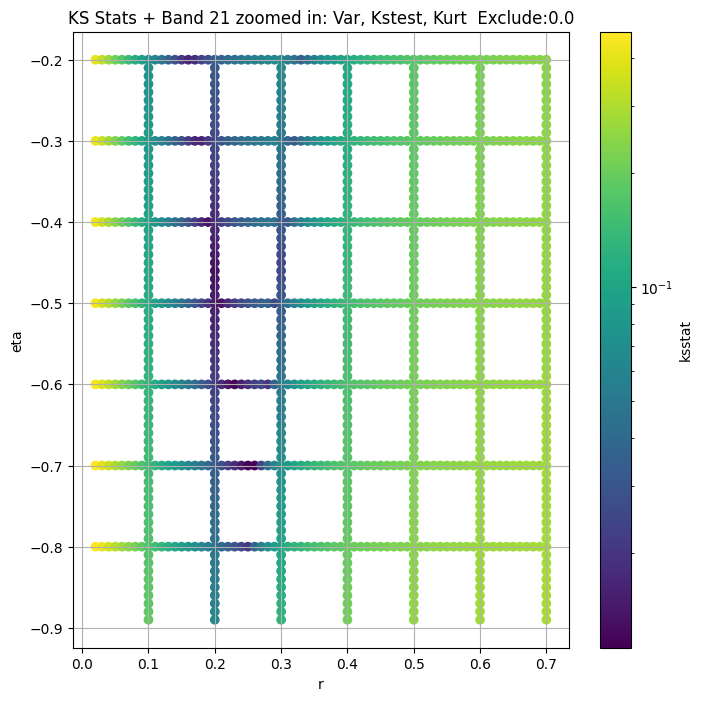

Band 24


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 0.0 + 100 = 100, ksstat: 0.00880651247786391, var: 19924782.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 0.0 + 75 = 75, ksstat: 0.009124664492792117, var: 20591980.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 0.0 + 50 = 50, ksstat: 0.008561758033319676, var: 21338630.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 0.0 + 25 = 25, ksstat: 0.007583243596744518, var: 22203280.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 0.0 + 0 = 0, ksstat: 0.007181350280957122, var: 23329316.0
Number of samples: 100000, Without approximation : 100000.0


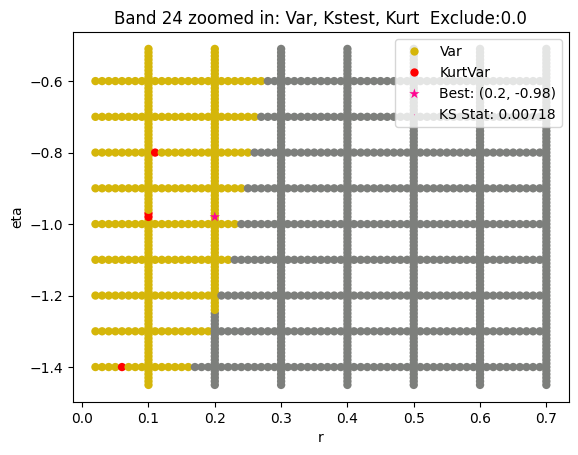

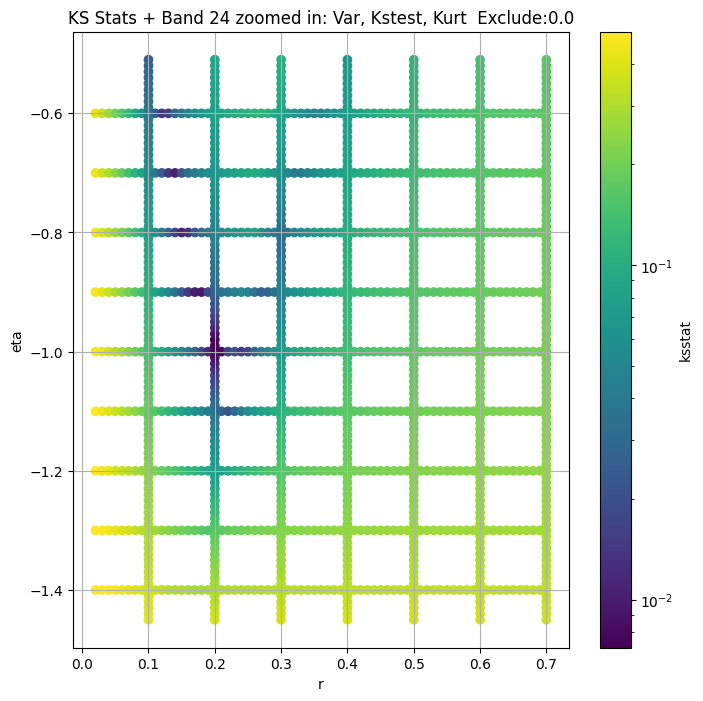

Band 27


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 27, 75.0 + 100 = 175, ksstat: 0.010167400960994555, var: 8625216.0


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 27, 75.0 + 75 = 150, ksstat: 0.010079218103793974, var: 8907322.0


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 27, 75.0 + 50 = 125, ksstat: 0.009823019404250899, var: 9211898.0


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 27, 75.0 + 25 = 100, ksstat: 0.009381482638365135, var: 9543398.0


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 27, 75.0 + 0 = 75, ksstat: 0.00975538530321185, var: 9908300.0


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 27, 75.0 + -25 = 50, ksstat: 0.010086154753345677, var: 10317304.0


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 27, 75.0 + -50 = 25, ksstat: 0.010925677250121002, var: 10791632.0


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 27, 75.0 + -75 = 0, ksstat: 0.01121753645968171, var: 11405998.0
Number of samples: 100000, Without approximation : 100000.0


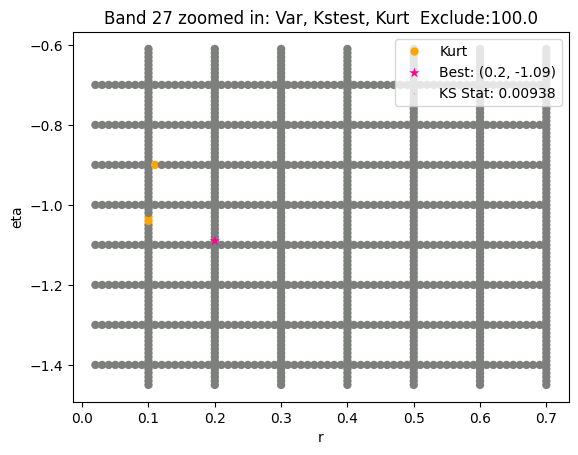

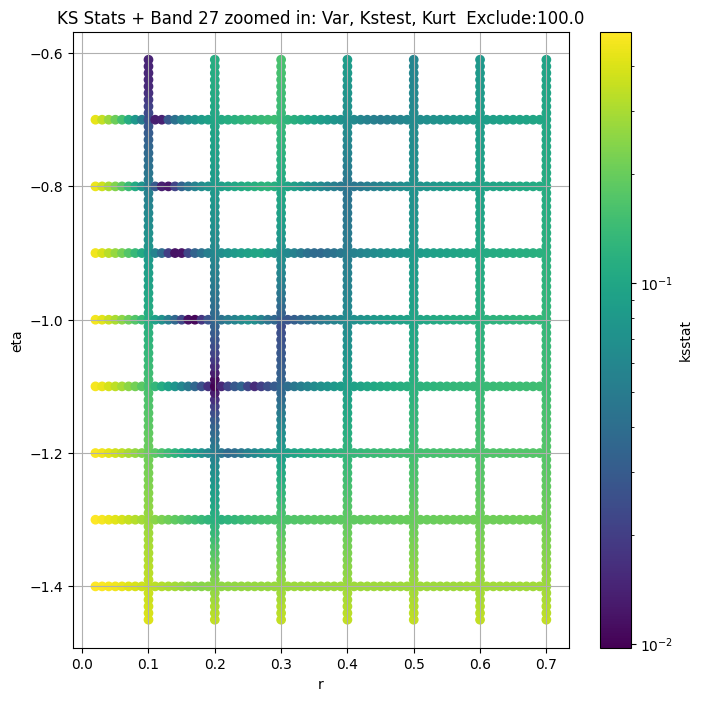

Band 31


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 31, 350.0 + 100 = 450, ksstat: 0.02430602334059012, var: 139922.9375


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 31, 350.0 + 75 = 425, ksstat: 0.024323262396964584, var: 143822.640625


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 31, 350.0 + 50 = 400, ksstat: 0.024323262396964584, var: 147926.71875


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 31, 350.0 + 25 = 375, ksstat: 0.024323262396964584, var: 152254.09375


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 31, 350.0 + 0 = 350, ksstat: 0.024323262396964584, var: 156827.09375


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 31, 350.0 + -25 = 325, ksstat: 0.024323262396964584, var: 161669.5


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 31, 350.0 + -50 = 300, ksstat: 0.024323262396964584, var: 166811.203125


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 31, 350.0 + -75 = 275, ksstat: 0.024323262396964584, var: 172288.265625


  0%|          | 0/1091 [00:00<?, ?it/s]

Finding Minimum after computing 1091 CDFs
band 31, 350.0 + -100 = 250, ksstat: 0.024323262396964584, var: 178136.890625
Number of samples: 100000, Without approximation : 100000.0


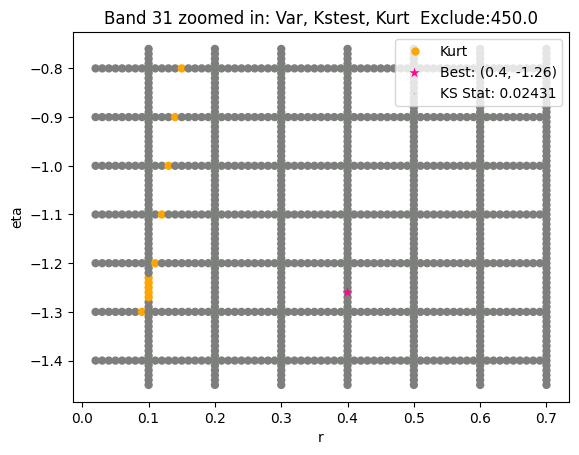

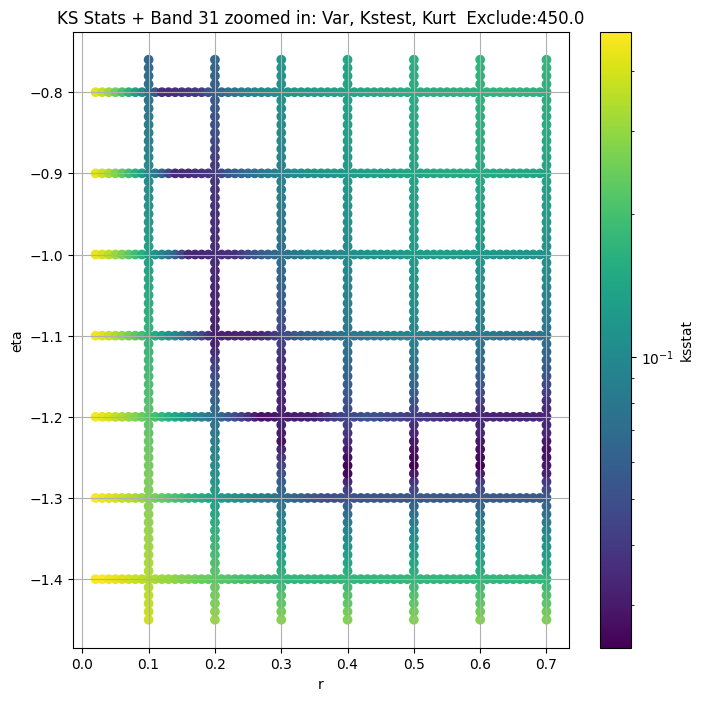

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     9.304439e+08  8.450695e+08  1.021509e+09  11.473390    9.685302   
5     2.322291e+09  2.175008e+09  2.474092e+09   4.320653    3.779683   
8     1.710829e+09  1.607269e+09  1.818124e+09   3.818767    3.301207   
11    1.497775e+09  1.413093e+09  1.583780e+09   2.941873    2.638871   
14    3.499311e+08  3.208751e+08  3.802060e+08   8.869143    7.774240   
18    7.146146e+07  6.552034e+07  7.788669e+07   9.265934    7.092388   
21    2.790665e+07  2.514312e+07  3.095792e+07  14.160641   10.133566   
24    2.332932e+07  2.041269e+07  2.649432e+07  23.594398   19.808994   
27    1.140600e+07  9.829746e+06  1.310639e+07  29.102272   24.468290   
31    2.927760e+05  2.422451e+05  3.579953e+05  55.067830   33.236103   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      14.099253       100000.0             0.023567        0.1          0.0   
5       4.902255       100000.0             0.032170        0.2         -0.1   
8       4.360001       100000.0             0.023749        0.2          0.5   
11      3.259851       100000.0             0.030077        0.2          0.1   
14     10.038318       100000.0             0.017438        0.2         -0.5   
18     12.380857       100000.0             0.016094        0.2         -0.2   
21     20.465760       100000.0             0.014833        0.2         -0.4   
24     27.871244       100000.0             0.008031        0.2         -1.0   
27     34.380190       100000.0             0.009755        0.2         -1.1   
31    140.556670       100000.0             0.031095        0.2         -1.1   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2          0.000131                     0.0        9.304439e+08   
5      41246.286869                    25.0        2.322291e+09   
8       6926.284915                    50.0        1.663971e+09   
11     15603.532660                    25.0        1.497775e+09   
14     22604.920635                    25.0        3.499311e+08   
18      1728.882423                     0.0        7.146146e+07   
21      1190.839701                    50.0        2.790665e+07   
24     16573.162660                     0.0        2.332932e+07   
27     13761.527778                    75.0        9.543398e+06   
31       217.815408                   350.0        1.399229e+05   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.004293          0.021626    0.13     -0.40   
5                    0.004293          0.031661    0.20     -0.12   
8                    0.004293          0.023108    0.22      0.30   
11                   0.004293          0.029523    0.21      0.00   
14                   0.004293          0.016949    0.20     -0.51   
18                   0.004293          0.015092    0.25     -0.50   
21                   0.004293          0.011246    0.26     -0.70   
24                   0.004293          0.007181    0.20     -0.98   
27                   0.004293          0.009381    0.20     -1.09   
31                   0.004293          0.024306    0.40     -1.26   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2         6.042405                  0.0         3952  
5     44359.719905                  0.0         1756  
8     50261.520122                 50.0         3514  
11    44601.600721                  0.0         2221  
14    24026.218023                  0.0         6250  
18    85073.171429                  0.0         7908  
21    96183.777627                  0.0        14062  
24    14660.080761                  0.0     

In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

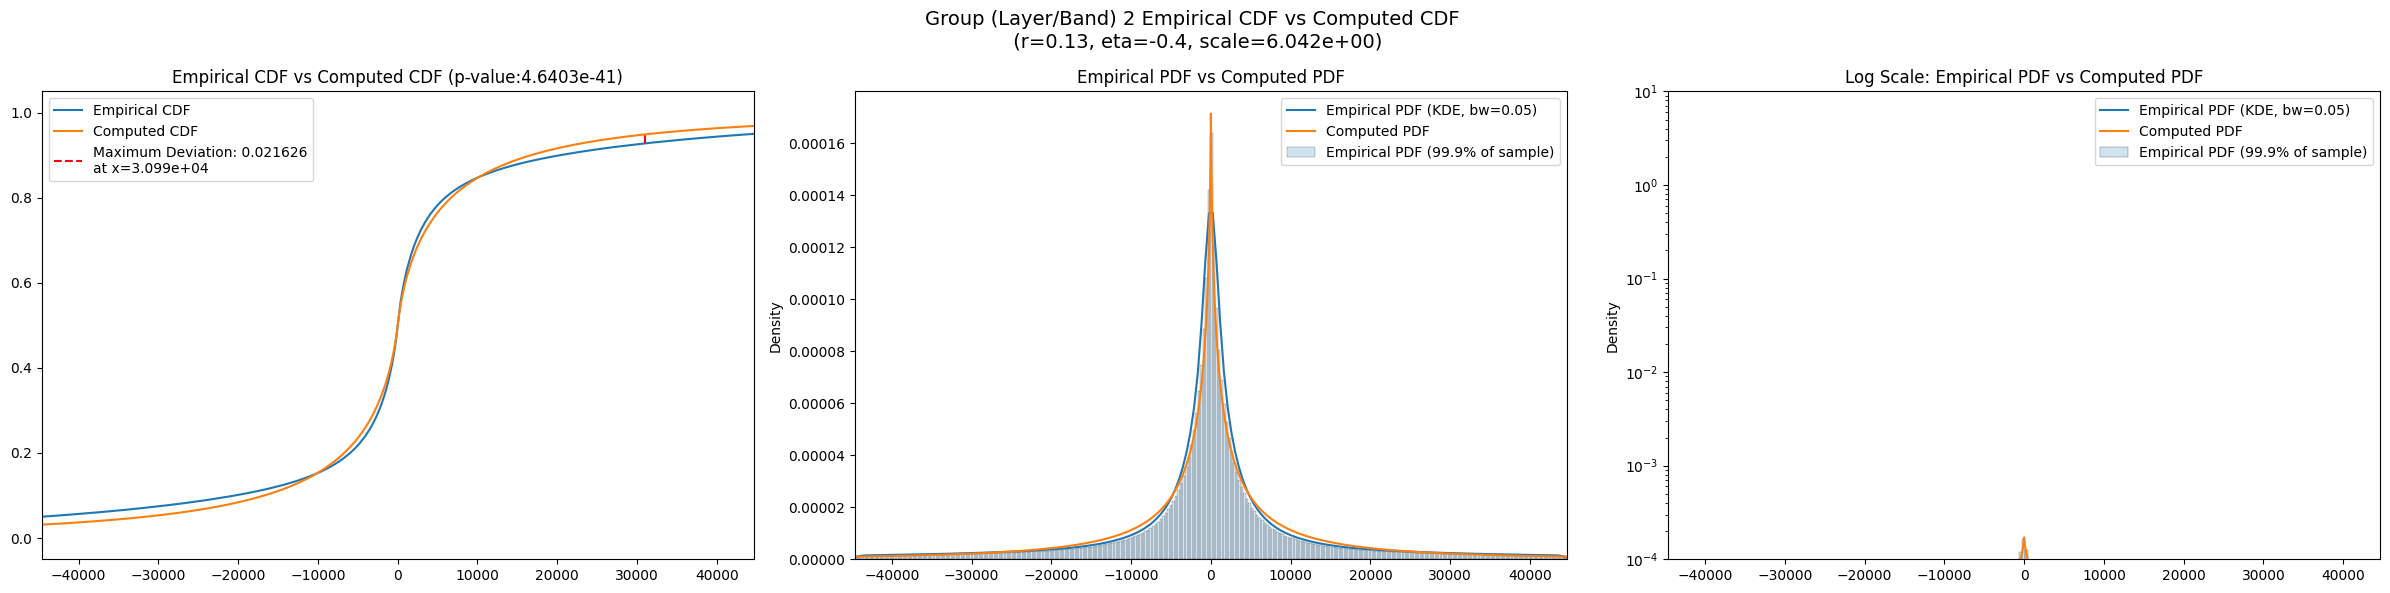

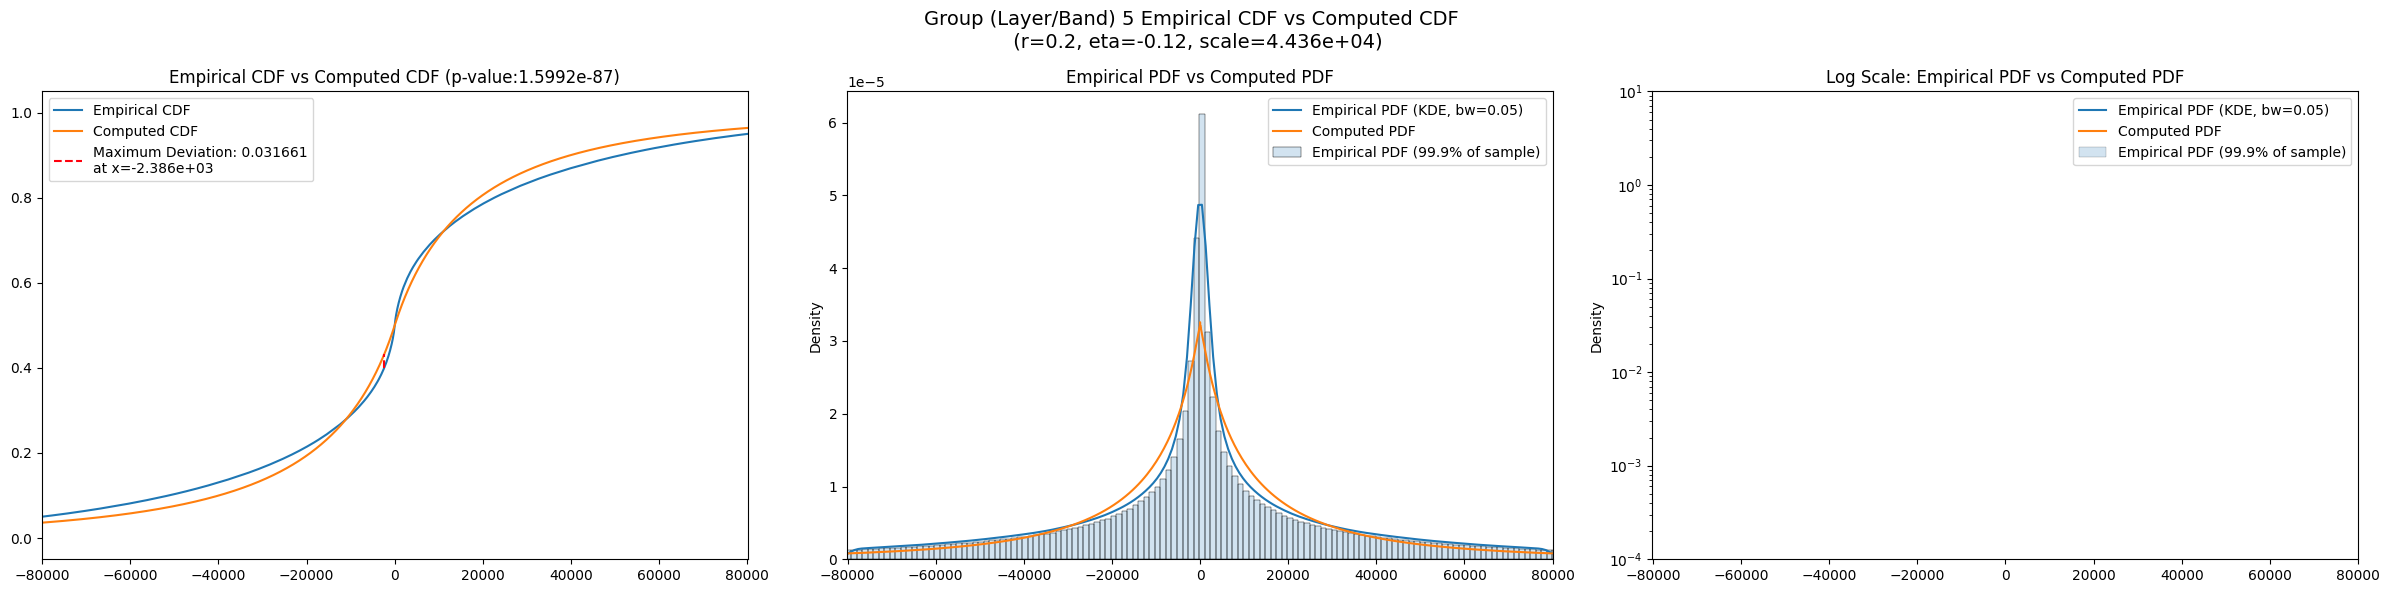

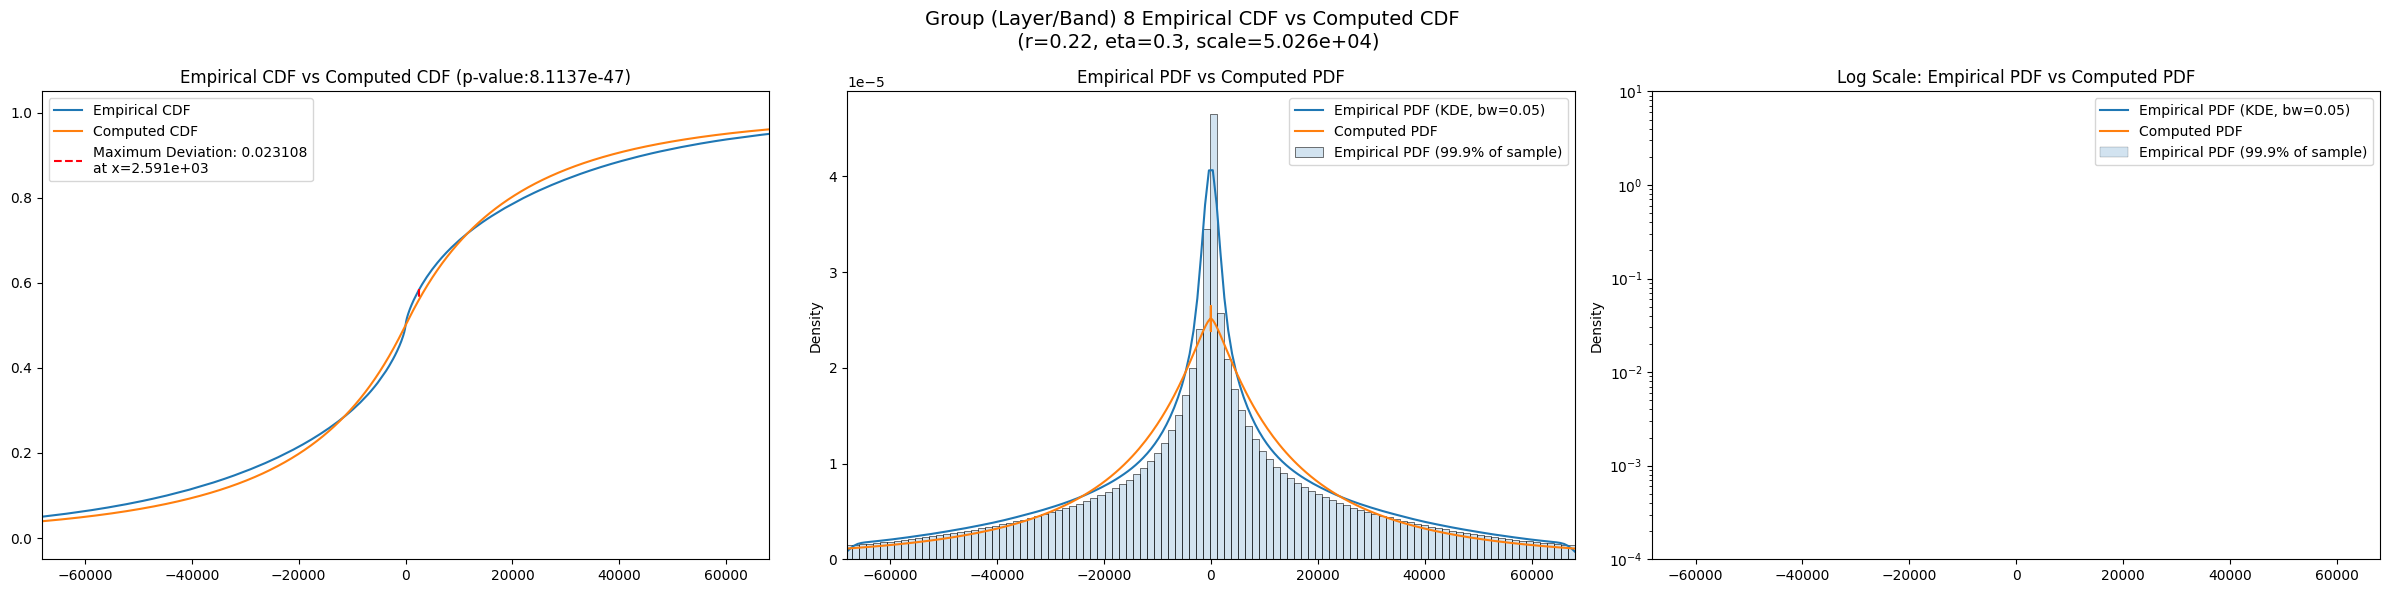

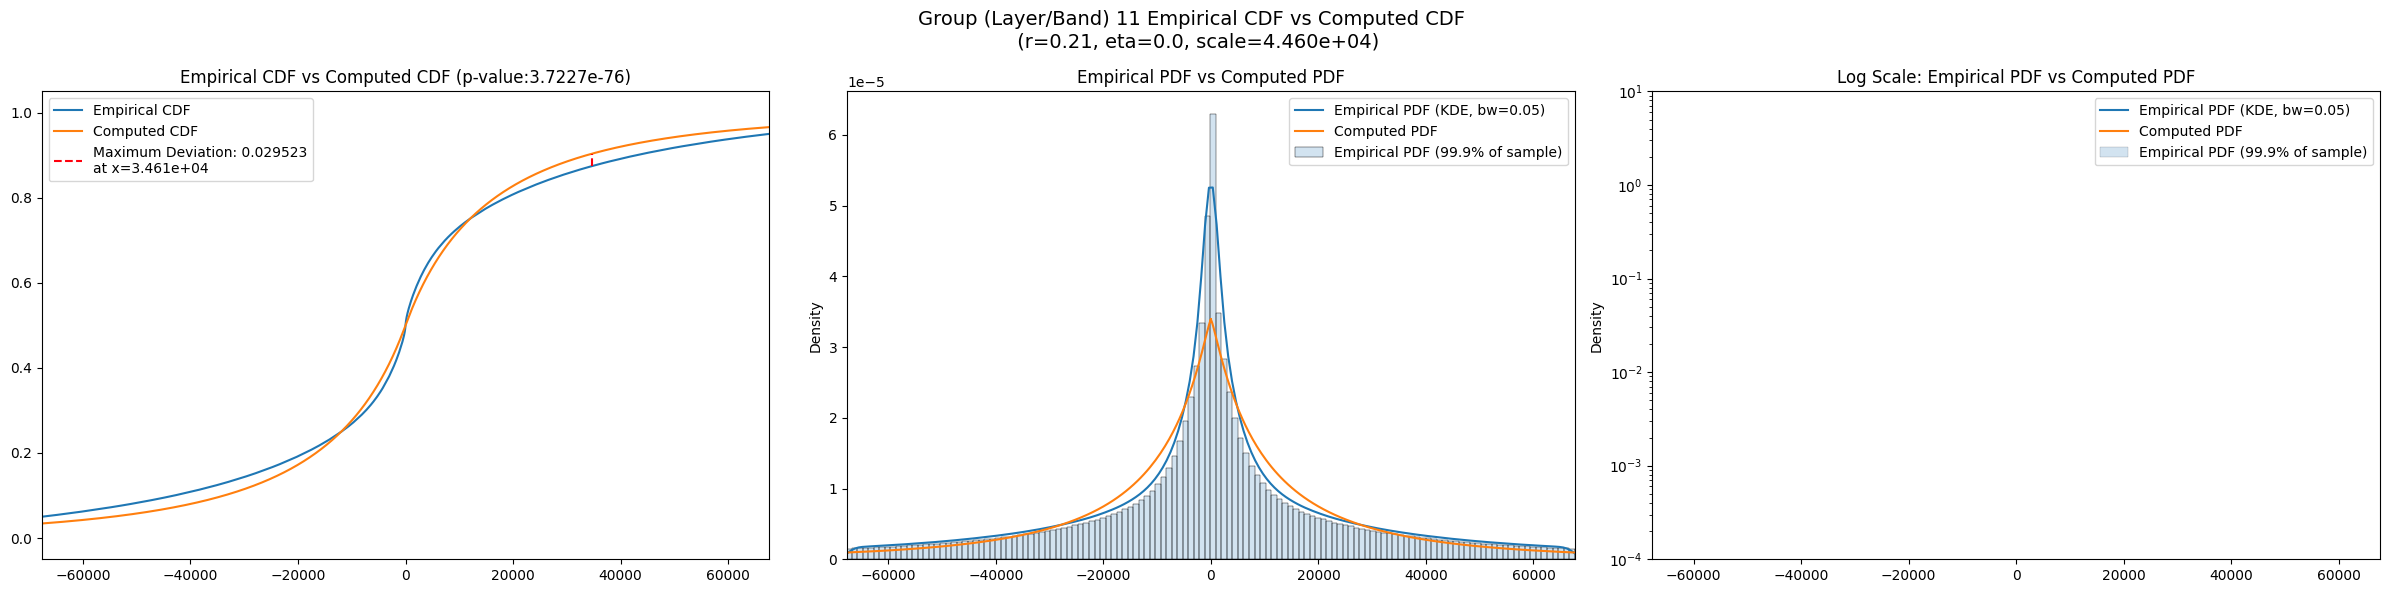

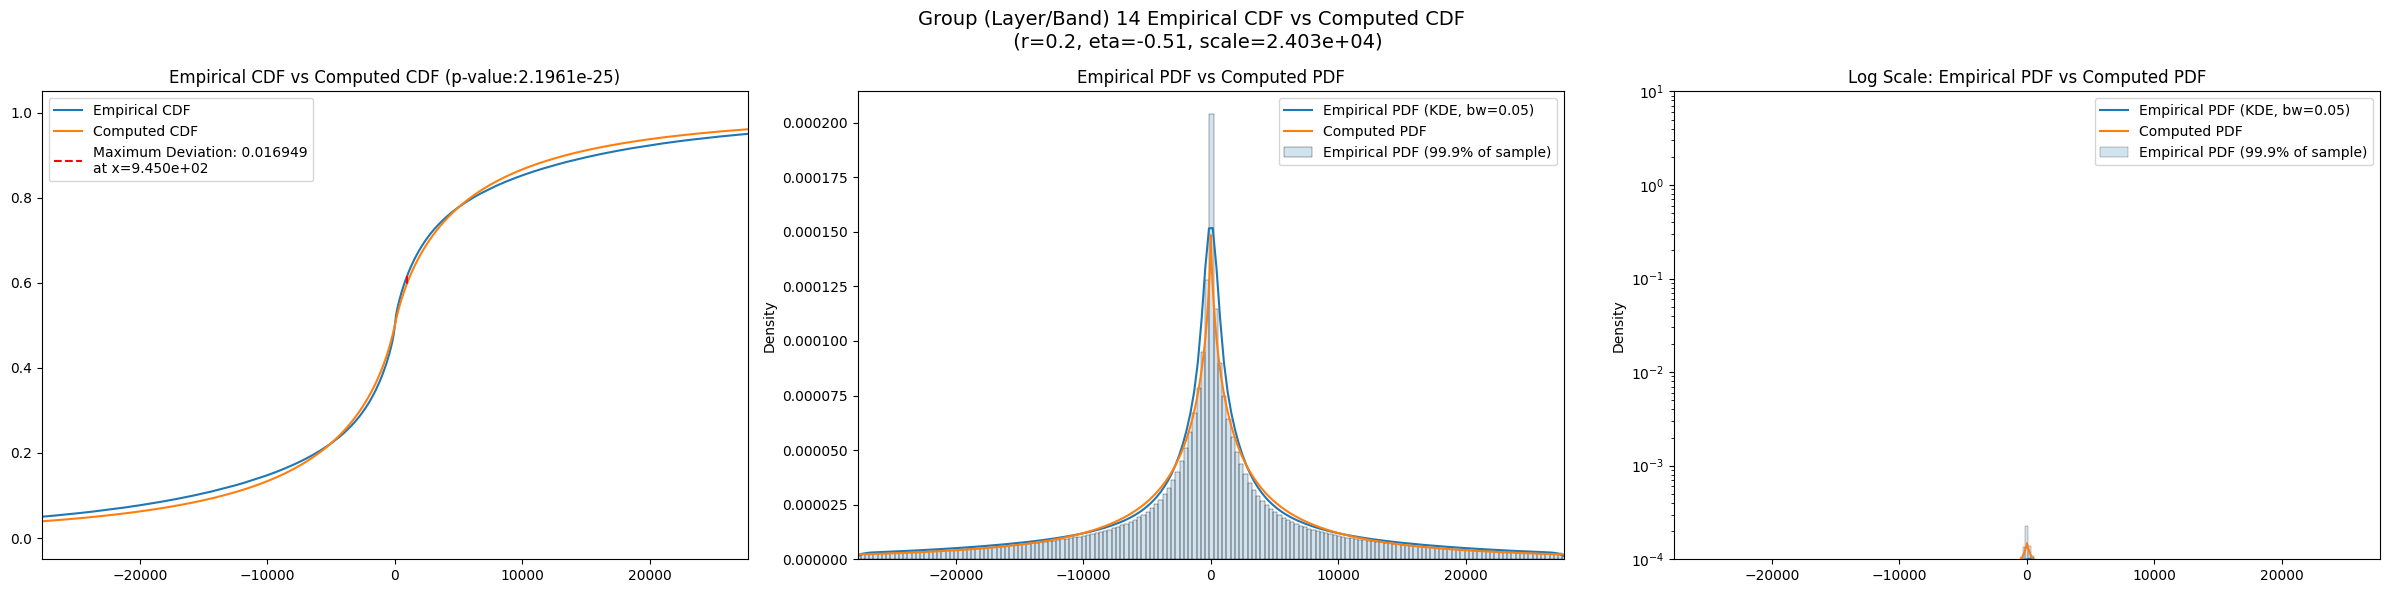

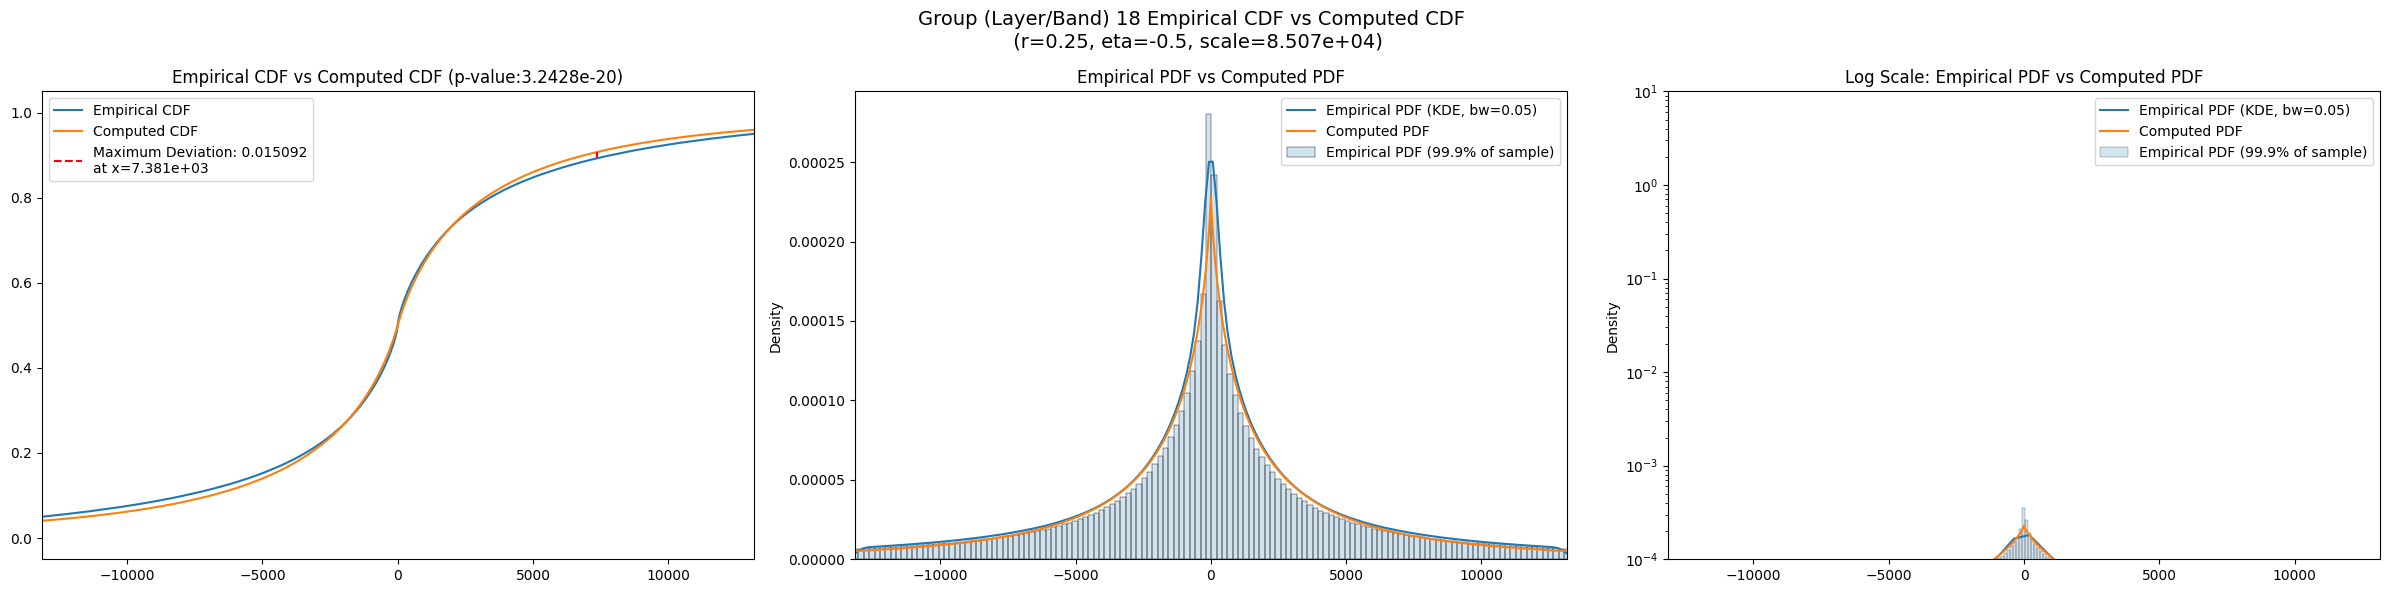

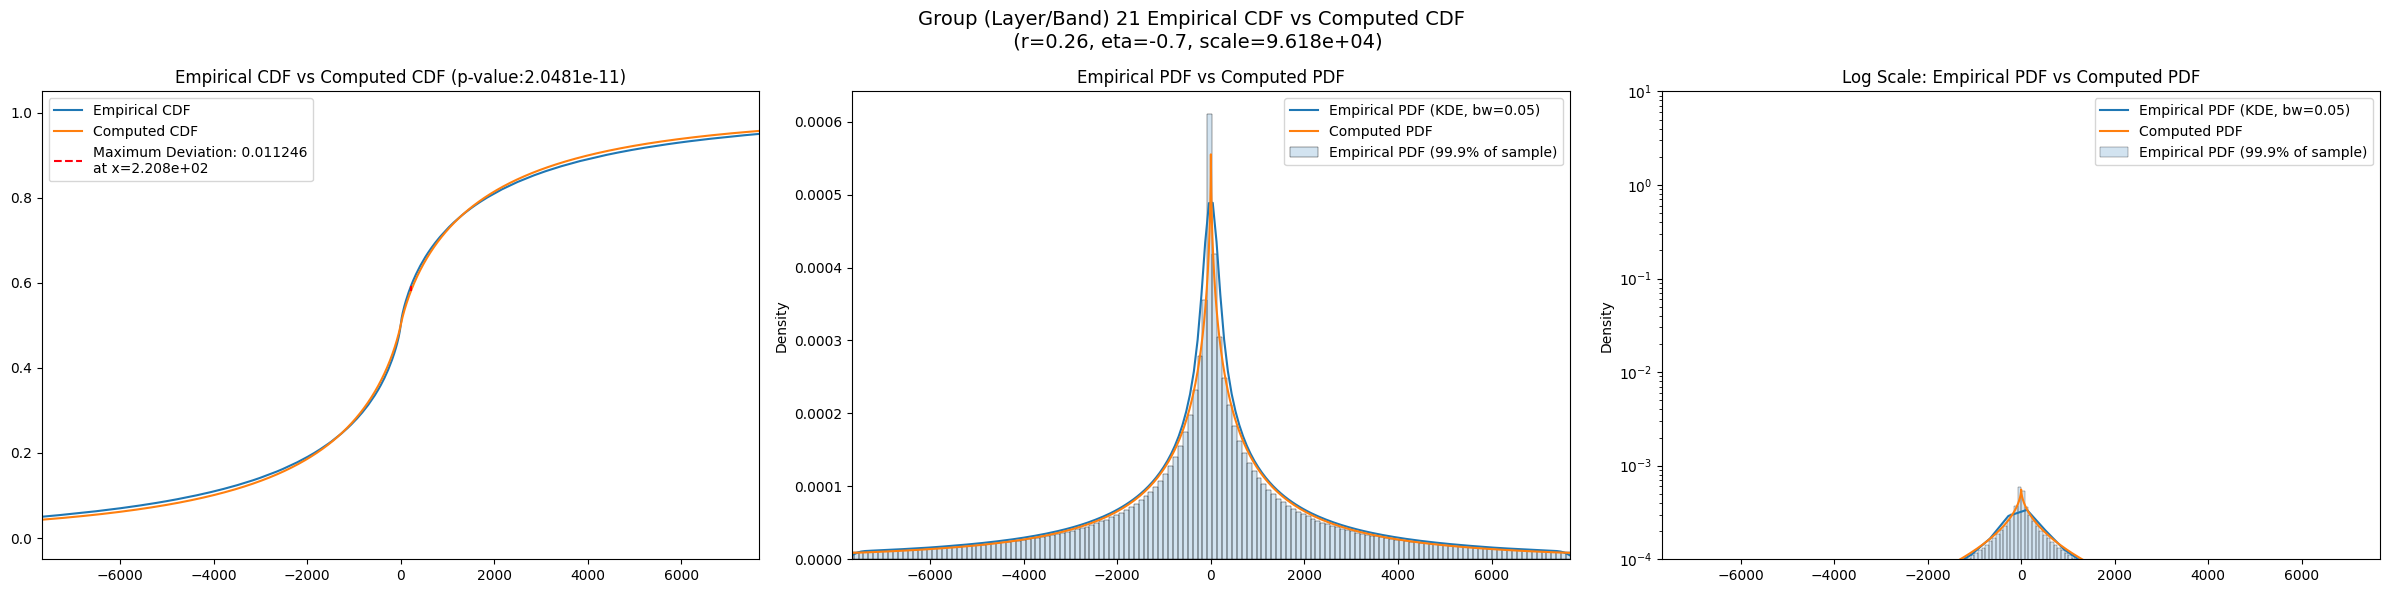

C:\Users\Henry\AppData\Local\Temp\ipykernel_17520\82260372.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)


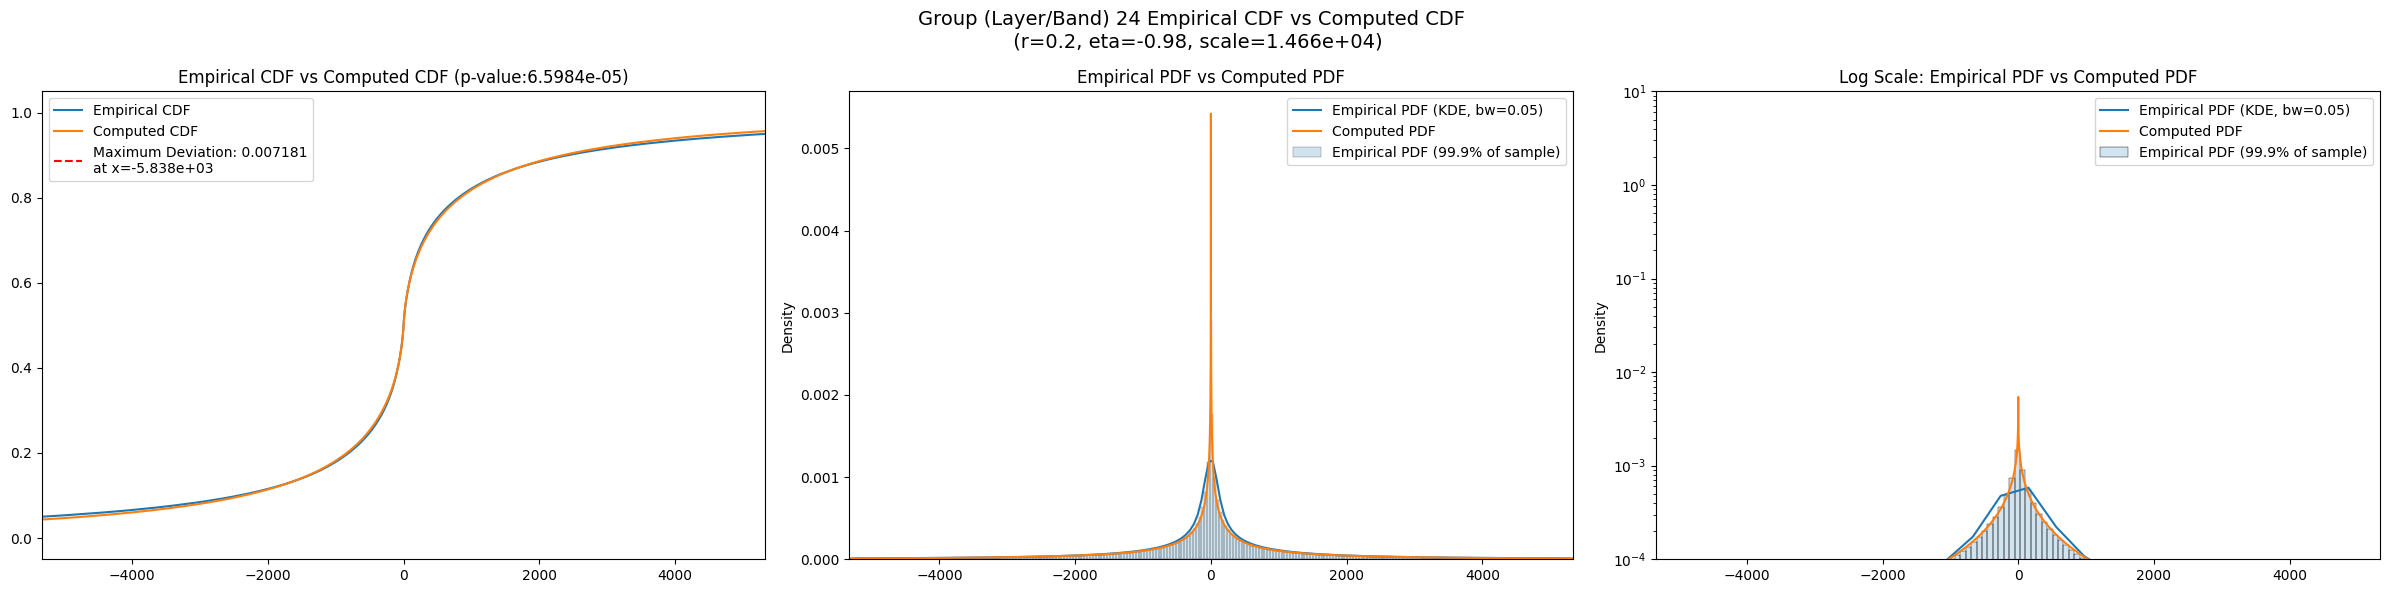

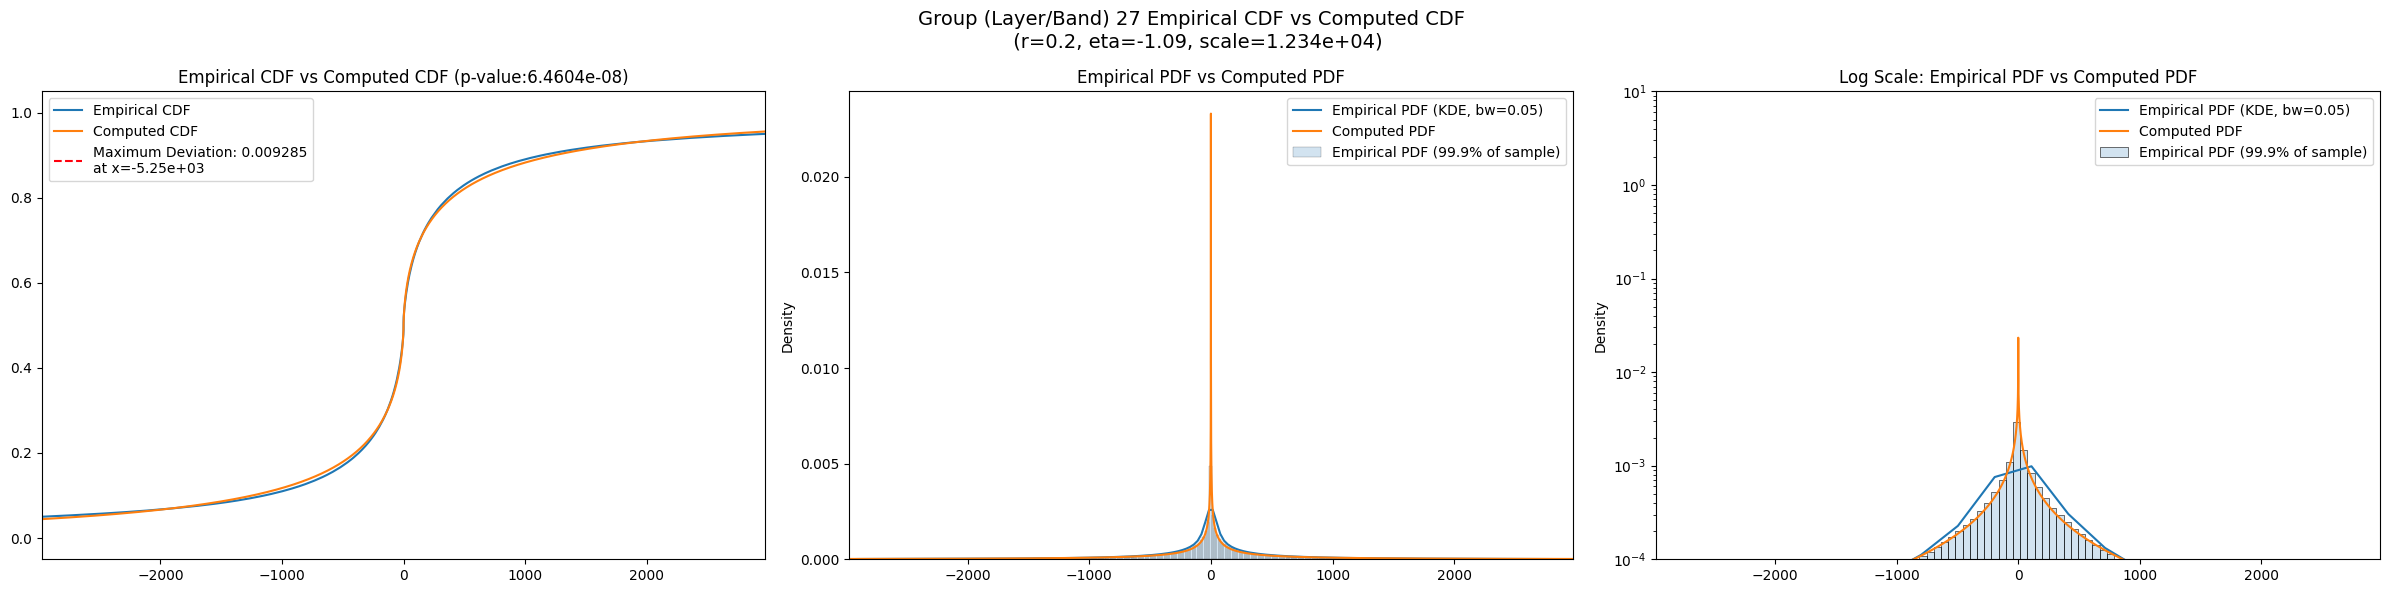

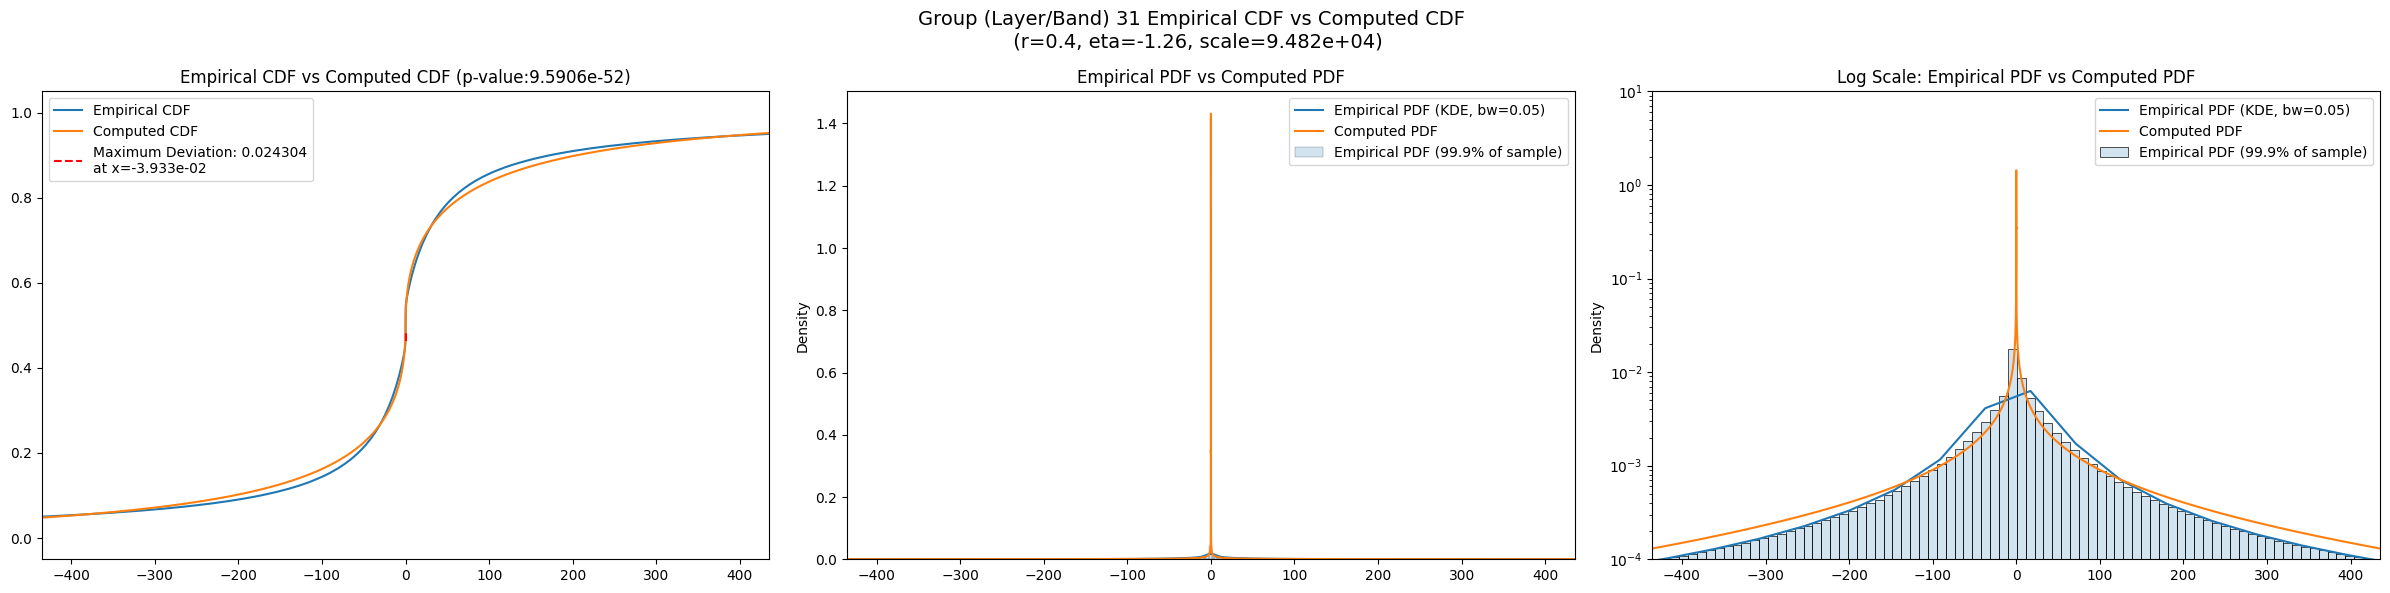

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     9.304439e+08  8.450695e+08  1.021509e+09  11.473390    9.685302   
5     2.322291e+09  2.175008e+09  2.474092e+09   4.320653    3.779683   
8     1.710829e+09  1.607269e+09  1.818124e+09   3.818767    3.301207   
11    1.497775e+09  1.413093e+09  1.583780e+09   2.941873    2.638871   
14    3.499311e+08  3.208751e+08  3.802060e+08   8.869143    7.774240   
18    7.146146e+07  6.552034e+07  7.788669e+07   9.265934    7.092388   
21    2.790665e+07  2.514312e+07  3.095792e+07  14.160641   10.133566   
24    2.332932e+07  2.041269e+07  2.649432e+07  23.594398   19.808994   
27    1.140600e+07  9.829746e+06  1.310639e+07  29.102272   24.468290   
31    2.927760e+05  2.422451e+05  3.579953e+05  55.067830   33.236103   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      14.099253       100000.0             0.023567        0.1          0.0   
5       4.902255       100000.0             0.032170        0.2         -0.1   
8       4.360001       100000.0             0.023749        0.2          0.5   
11      3.259851       100000.0             0.030077        0.2          0.1   
14     10.038318       100000.0             0.017438        0.2         -0.5   
18     12.380857       100000.0             0.016094        0.2         -0.2   
21     20.465760       100000.0             0.014833        0.2         -0.4   
24     27.871244       100000.0             0.008031        0.2         -1.0   
27     34.380190       100000.0             0.009755        0.2         -1.1   
31    140.556670       100000.0             0.031095        0.2         -1.1   

      ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band  ...                                                               
2     ...       8541.1200              0.092263          0.000000e+00   
5     ...      26246.0000              0.075165          0.000000e+00   
8     ...      26249.1000              0.057090         9.534810e-284   
11    ...      22255.8000              0.073700          0.000000e+00   
14    ...       7788.1300              0.078905          0.000000e+00   
18    ...       4381.1300              0.066367          0.000000e+00   
21    ...       2335.8300              0.071142          0.000000e+00   
24    ...       1039.9900              0.091000          0.000000e+00   
27    ...        482.0210              0.091966          0.000000e+00   
31    ...         76.8922              0.088305          0.000000e+00   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace     param_t  \
band                                                                        
2         7613.3200             0.068122         0.000000e+00   5764.0600   
5        22129.2000             0.051368        9.063700e-230  17659.4000   
8        22419.9000             0.032155         2.918450e-90  18239.6000   
11       19093.4000             0.047785        7.151240e-199  15225.2000   
14        6734.3000             0.052838        4.365610e-243   5267.4400   
18        3787.3000             0.040114        2.989990e-140   2975.2800   
21        2013.3000             0.045590        4.667400e-181   1570.6700   
24         905.4330             0.067074         0.000000e+00    684.4590   
27         421.6460             0.069071         0.000000e+00    313.9270   
31          67.3477             0.065836         0.000000e+00     49.5571   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.064787   0.000000e+00          4.640747e-41  
5          0.055099  2.608480e-264          1.599198e-87  
8          0.037237  6.565630e-121          8.113753e-47  
11         0.050943  5.500860e-226          3.723098e-76  
14         0.0540

## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.023567                 0.004293          0.021626   
5                0.032170                 0.004293          0.031661   
8                0.023749                 0.004293          0.023108   
11               0.030077                 0.004293          0.029523   
14               0.017438                 0.004293          0.016949   
18               0.016094                 0.004293          0.015092   
21               0.014833                 0.004293          0.011246   
24               0.008031                 0.004293          0.007181   
27               0.009755                 0.004293          0.009381   
31               0.031095                 0.004293          0.024306   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.092263             0.068122       0.064787  
5                 0.075165             0.051368       0.055099  
8                 0.057090             0.032155       0.037237  
11                0.073700             0.047785       0.050943  
14                0.078905             0.052838       0.054007  
18                0.066367             0.040114       0.041949  
21                0.071142             0.045590       0.047010  
24                0.091000             0.067074       0.065842  
27                0.091966             0.069071       0.067128  
31                0.088305             0.065836       0.064045

In [21]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2           9.304439e+08          0.021626    0.13     -0.40      6.042405   
5           2.322291e+09          0.031661    0.20     -0.12  44359.719905   
8           1.663971e+09          0.023108    0.22      0.30  50261.520122   
11          1.497775e+09          0.029523    0.21      0.00  44601.600721   
14          3.499311e+08          0.016949    0.20     -0.51  24026.218023   
18          7.146146e+07          0.015092    0.25     -0.50  85073.171429   
21          2.790665e+07          0.011246    0.26     -0.70  96183.777627   
24          2.332932e+07          0.007181    0.20     -0.98  14660.080761   
27          9.543398e+06          0.009381    0.20     -1.09  12335.238750   
31          1.399229e+05          0.024306    0.40     -1.26  94817.178384   

      best_exclude_cutoff  
band                       
2                     0.0  
5                     0.0  
8                    50.0  
11                    0.0  
14                    0.0  
18                    0.0  
21                    0.0  
24                    0.0  
27                  100.0  
31                  450.0